# Preamble

In [1]:
import numpy as np
import astropy.table as tbl
import os, os.path
import healpy as hp
from astropy.io import ascii
import random
import matplotlib.pyplot as plt
import pymaster as nmt
from kmeans_radec import KMeans, kmeans_sample
import matplotlib
import pickle
from collections import OrderedDict
from astropy.table import QTable
from datetime import datetime
from scipy.interpolate import interp1d

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Config

In [2]:
#IceCube dataset
ICDataset = 10 #IceCube dataset to use (either 3 or 10)
if ICDataset == 3:
    ICEventDir = 'IceCube_dataset3' #directory containing IceCube event files
    ICEffAreaDir = 'IceCube_dataset3' #directory containing IceCube effective area files
    ICEventKW = 'events.txt' #IceCube event files keyword
    ICAeffKW = 'TabulatedAeff.txt' #IceCube effective area files keyword
    ICEvOrderFiles = [0,1,2] #converts alphanumeric order to chronological order
    ICAeffOrderFiles = [0,1,2] #converts alphanumeric order to chronological order
    ICAeffMinECol = 'E_min[GeV]' #name of min energy column in Aeff table
    ICAeffMaxECol = 'E_max[GeV]' #name of max energy column in Aeff table
    ICAeffMinDecCol = 'cos(zenith)_min' #name of min cos(zenith) column in Aeff table
    ICAeffMaxDecCol = 'cos(zenith)_max' #name of max cos(zenith) column in Aeff table
    ICAeffCol = 'Aeff[m^2]' #name of Aeff column in Aeff table
    ICAeffUnits = 1 #factor to convert Aeff to m^2
elif ICDataset == 10:
    ICEventDir = 'IceCube_dataset10/events' #directory containing IceCube event files
    ICEffAreaDir = 'IceCube_dataset10/irfs' #directory containing IceCube event files
    ICEventKW = 'exp.csv' #IceCube event files keyword
    ICAeffKW = 'Area.csv' #IceCube effective area files keyword
    ICEvOrderFiles = [0,1,2,6,4,3,5,9,8,7] #converts alphanumeric order to chronological order
    ICAeffOrderFiles = [0,1,2,4,3] #converts alphanumeric order to chronological order
    ICAeffMinECol = 'log10(E_nu/GeV)_min' #name of min energy column in Aeff table
    ICAeffMaxECol = 'log10(E_nu/GeV)_max' #name of max energy column in Aeff table
    ICAeffMinDecCol = 'Dec_nu_min[deg]' #name of min declination column in Aeff table
    ICAeffMaxDecCol = 'Dec_nu_max[deg]' #name of max declination column in Aeff table
    ICAeffCol = 'A_Eff[cm^2]' #name of Aeff column in Aeff table
    ICAeffUnits = 0.0001 #factor to convert Aeff to m^2
else:
    print('Invalid IceCube dataset specified.')

In [3]:
#effective area lookup table
AeffTblZenStepSize = 0.01 #step size of cos(zenith) angle in effective area tables
AeffTblZenRange = 2 #range of cos(zenith) angles in effective area tables
UseAeffWeights = True #whether to use aeff weights

#weighted effective area
ESpectralIndex = 3.7 #assumed energy spectral index of events
AeffMaskFrac = 0.10 #fractional cutoff (with 1 being maximum Aeff) to mask weighted effective area maps
InterpolateWeightedAeff = True #whether to use interpolation weighted effective area (False currently broken)
#only for non-interpolation method:
ImportWeightedAeffMap = False #whether to import weighted effective areas from disk or calculate
if ICDataset == 3:
    ImportWeightedAeffPath = 'WeightedAeffMap/3yr' #directory containing weighted Aeff maps for 3 years
elif ICDataset == 10:
    ImportWeightedAeffPath = 'WeightedAeffMap/10yr' #directory containing weighted Aeff maps for 10 years
PlotWeightedAeffMap = False #whether to display weighted effective area maps

#plotting IceCube neutrino maps
NSIDE = 128 #set NSIDE parameter for healpix map
NPIX = hp.nside2npix(NSIDE) #number of pixels of healpix map
ICDecMin = -5 #neutrino events below this declination are ignored
#(some above this declination may also be ignored due to Aeff masks)
#ICEMapBands = [(1.5,2.5),(2.5,3.5),(3.5,4.5), #energy bins of neutrino maps
               #(4.5,5.5),(5.5,6.5)]
ICEMapBands = [(2,3),(3,4),(4,5),(5,6)]
#ICEMapBands = [(4,5)] #list of tuples for custom energy bins

In [4]:
#loading in galaxy maps
GalMapDir = 'Galaxy_Maps' #directory containing galaxy maps (and mask)
GalMapKW = 'map' #galaxy map files keyword
GalMaskKW = 'mask' #galaxy mask file keyword

In [5]:
#NaMaster C_l approximation
LPerBP = 50 #number of l values per bandpower
ApodScale = 1 #scale on which masks are apodized (in degrees)

#Jackknife errors on c_l
ImportJKcls = False #whether to import jackknife cls from disk or calculate from scratch
if ICDataset == 3:
    if UseAeffWeights == False:
        ImportJKclsPath = 'JKcls/3yrNoWeight' #directory containing jackknife cls for 3 years, no weights
    else:
        ImportJKclsPath = 'JKcls/3yrWeight' #directory containing jackknife cls for 3 years, weights
elif ICDataset == 10:
    if UseAeffWeights == False:
        ImportJKclsPath = 'JKcls/10yrNoWeight' #directory containing jackknife cls for 10 years, no weights
    else:
        ImportJKclsPath = 'JKcls/10yrWeight' #directory containing jackknife cls for 10 years, weights
JKRegions = 100 #number of regions to use to calculate jackknife errors
lmin = 50 #minimum l value to use in likelihood calculation

CrossSpectraPDF = True #whether to save pdf of cross-correlation angular power spectra (with errors)

# IceCube Data

## Loading Data

In [6]:
#finds filenames of all IceCube files, sorted alphanumerically
ICEventFilenames = sorted(os.listdir(ICEventDir))
ICEffAreaFilenames = sorted(os.listdir(ICEffAreaDir))

#selects event data and effective area data IceCube files
ICEvFilenamesUnorder = []
ICAeffFilenamesUnorder = []
for i in ICEventFilenames: #only appends files to corresponding lists if keywords contained in filenames
    if ICEventKW in i:
        ICEvFilenamesUnorder.append(i)
for i in ICEffAreaFilenames:
    if ICAeffKW in i:
        ICAeffFilenamesUnorder.append(i)
        
#changes ordering of event data files to chronological 
ICEvFilenames = list(str(' ' * len(ICEvFilenamesUnorder)))
for i in range(len(ICEvFilenames)):
    ICEvFilenames[i] = ICEvFilenamesUnorder[ICEvOrderFiles[i]]
    
#changes ordering of uptime data files to chronological
ICAeffFilenames = list(str(' ' * len(ICAeffFilenamesUnorder)))
for i in range(len(ICAeffFilenames)):
    ICAeffFilenames[i] = ICAeffFilenamesUnorder[ICAeffOrderFiles[i]]
#these only work if filenames have been unaltered from default, otherwise ICOrderFiles will be wrong

#all later seasons use 2012 effective area table
while len(ICAeffFilenames) < len(ICEvFilenames):
    ICAeffFilenames.append(ICAeffFilenames[-1])


In [7]:
#reads in IceCube effective area data from chosen directory for each year
ICAeffList = []
for i in ICAeffFilenames:
    ICAeffList.append(tbl.Table.read(ICEffAreaDir + '/' + i, format = 'ascii'))
    
#reads in IceCube neutrino event data from chosen directory for each year
ICEventList = []
for i in range(len(ICEvFilenames)):
    ICEventData = tbl.Table.read(ICEventDir + '/' + ICEvFilenames[i], format = 'ascii')
    ICEventData['Year'] = np.full(len(ICEventData), i) #add column for year each neutrino event is from
    ICEventList.append(ICEventData)

#combines neutrino event data into a single table
ICEventFull = tbl.vstack(ICEventList)

## Effective Area

### Functions

In [8]:
#finds effective area of an energy and declination angle
def AeffLookup(AeffTbl, E, Dec, DatasetYrs = ICDataset, AeffMinECol = ICAeffMinECol, 
               AeffMaxECol = ICAeffMaxECol, AeffMinDecCol = ICAeffMinDecCol, 
               AeffMaxDecCol = ICAeffMaxDecCol, AeffCol = ICAeffCol, AeffUnits = ICAeffUnits):
    #AeffTbl - effective area table to use
    #E - energy to look up (input in log scale)
    #Dec - declination angle to look up (input in degrees)
    #DatasetYrs - which dataset is being used (3 or 10 years)
    #AeffMinECol, AeffMaxECol - min/max energy column headers in Aeff tables
    #AeffMinZenCol, AeffMaxZenCol - min/max zenith/declination column headers in Aeff tables
    #AeffCol - Aeff column header in Aeff tables
    #AeffUnits - factor to convert Aeff to m^2
    
    if DatasetYrs == 3:
        Dec = np.cos(np.radians(Dec+90)) #converts to cos(zenith)
        E = 10**E #converts from log scale
    
    #checks upper and lower bounds of energy and declination angle
    MinECheck = np.where(E >= AeffTbl[AeffMinECol], True, False)
    MaxECheck = np.where(E <= AeffTbl[AeffMaxECol], True, False)
    MinDecCheck = np.where(Dec >= AeffTbl[AeffMinDecCol], True, False)
    MaxDecCheck = np.where(Dec <= AeffTbl[AeffMaxDecCol], True, False)
    
    #finds where all conditions are met
    AeffIndex = MinECheck * MaxECheck * MinDecCheck * MaxDecCheck
    
    return AeffTbl[AeffCol][AeffIndex][0] * AeffUnits #corrects units to m^2 in 10 year case

In [9]:
def WeightedEffArea(AeffTbl, WideELower, WideEUpper, theta, alpha = ESpectralIndex, 
                    DatasetYrs = ICDataset, AeffMinDecCol = ICAeffMinDecCol, 
                    AeffMaxDecCol = ICAeffMaxDecCol, AeffMinECol = ICAeffMinECol, 
                    AeffMaxECol = ICAeffMaxECol):
    #AeffTbl - effective area table to use
    #WideELower - lower energy band of bin
    #WideEUpper - upper energy band of bin
    #theta - declination angle(input in degrees)
    #alpha - energy spectral index of events
    #DatasetYrs - years of dataset (3 or 10)
    #AeffMinDecCol, AeffMaxDecCol - min/max zenith/declination column header in Aeff tables
    #AeffMinECol, AeffMaxECol - min/max energy column header in Aeff tables
    
    #finds energy bounds of table
    FineEBounds = list(OrderedDict.fromkeys(AeffTbl[AeffMinECol]))
    FineEBounds.append(AeffTbl[AeffMaxECol][-1])
    
    if DatasetYrs == 3:
        FineEBounds = np.log10(np.array(FineEBounds))
    
    #finds relevant fine energy bins
    MinEBoundCheck = np.where(WideELower <= np.array(FineEBounds), True, False)
    MaxEBoundCheck = np.where(WideEUpper >= np.array(FineEBounds), True, False)
    UsefulFineEBounds = list(np.array(FineEBounds)[MinEBoundCheck * MaxEBoundCheck])
    UsefulFineEBounds.insert(0, WideELower)
    UsefulFineEBounds.append(WideEUpper)
    
    #converts from log scale
    LinFineE = 10**np.array(UsefulFineEBounds)
    WideEL = 10**WideELower
    WideEU = 10**WideEUpper
    
    #variable to return
    WeightedAeff = 0
    
    #sums over each fine bin
    for i in range(len(UsefulFineEBounds) - 1):
        SumAeff = AeffLookup(AeffTbl, (UsefulFineEBounds[i]+UsefulFineEBounds[i+1])/2, theta) #effective area
        SumNum = SumAeff * (LinFineE[i+1]**(1-alpha) - LinFineE[i]**(1-alpha)) #sum numerator
        SumDenom = (WideEU**(1-alpha) - WideEL**(1-alpha)) #sum denominator
        WeightedAeff += (SumNum/SumDenom) #adds this fine bin contribution to sum
        
    #returns weighted efffective area
    return WeightedAeff

### Interpolation Method

In [10]:
#defines coordinate transforms
equ2gal = hp.Rotator(coord = 'cg', deg = True)
gal2equ = hp.Rotator(coord = 'cg', deg = True, inv = True)

In [11]:
#use interpolation method
if InterpolateWeightedAeff == True:
    #finds middle points of sin(dec) bins in effective area tables
    if ICDataset == 3:
        SinDecVals = -np.unique((ICAeffList[0][ICAeffMinDecCol]+ICAeffList[0][ICAeffMaxDecCol])/2)
    elif ICDataset == 10:
        SinDecVals = np.sin(np.radians(np.unique((ICAeffList[0][ICAeffMinDecCol] + 
                                                 ICAeffList[0][ICAeffMaxDecCol])/2)))

    WeightedAeffInter = []
    for i in range(len(ICEMapBands)):
        WeightedAeffInter.append([])
        for j in ICAeffList:
            WeightedAeffVals = []
            for k in range(len(SinDecVals)):
                #finds weighted effective area for each sin(dec) bin
                WeightedAeffVals.append(WeightedEffArea(j, ICEMapBands[i][0], ICEMapBands[i][1], 
                                                        np.degrees(np.arcsin(SinDecVals[k]))))
            #creates interpolation function for each energy bin and season
            WeightedAeffInter[i].append(interp1d(SinDecVals, WeightedAeffVals, 
                                                 bounds_error=False, fill_value=0.0))

In [57]:
if InterpolateWeightedAeff == True:
    #finds interpolated weighted effective area map
    WeightedAeffMap = []
    for i in range(len(ICEMapBands)):
        WeightedAeffMap.append([])
        for j in range(len(ICAeffList)):
            WeightedAeffMap[i].append(np.zeros(NPIX))
            #finds sin(dec) for each pixel
            MapSinDecs = np.sin(np.radians(gal2equ(hp.pix2ang(NSIDE, np.arange(NPIX), lonlat = True), 
                                                   lonlat = True)[1]))
            #builds map using interpolation function
            WeightedAeffMap[i][j] += WeightedAeffInter[i][j](MapSinDecs)
            #hp.mollview(WeightedAeffMap[i][j])

### Non-interpolation Method

In [13]:
if InterpolateWeightedAeff == False: 
    if ImportWeightedAeffMap == False: 

        #finds all declination angles in healpy map and removes duplicates
        HealpyAllDecVals = hp.pix2ang(NSIDE, np.arange(NPIX), lonlat = True)[1]
        HealpyDecVals = np.array(list(OrderedDict.fromkeys(HealpyAllDecVals)))

        WeightedAeffTbl = []

        #creates lookup table for weighted effective areas across energy bins
        for i in range(len(ICEMapBands)): #loops through energy bins

            WeightedAeffTbl.append([])

            for j in range(len(ICAeffList)): #loops through seasons

                WeightedAeffTblCol = []

                for k in range(len(HealpyDecVals)): #checks each declination value and adds to new column 

                    #finds corresponding weighted effective area
                    WeightedAeffTblCol.append(WeightedEffArea(ICAeffList[j], ICEMapBands[i][0], 
                                                              ICEMapBands[i][1], HealpyDecVals[k]))

                #creates new table containing Aeff values
                WeightedAeffTbl[i].append(QTable([HealpyDecVals, WeightedAeffTblCol], 
                                          names = ('Dec[deg]', 'Aeff[m^2]')))

                print(f'Table {i*len(ICAeffList)+j+1} out of {len(ICEMapBands)*len(ICAeffList)} generated.')

In [14]:
if InterpolateWeightedAeff == False:
    if ImportWeightedAeffMap == False:

        WeightedAeffMap = []

        #plots weighted effective area on map for each year and energy bin
        for i in range(len(ICEMapBands)):

            WeightedAeffMap.append([])

            for j in range(len(ICAeffList)):

                WeightedAeffMap[i].append(np.ones(NPIX)) #creates base map

                #finds declination of this pixel
                MapDec = hp.pix2ang(NSIDE, np.arange(NPIX), lonlat = True)[1]

                #finds index of this angle in lookup table
                MapDecIndices = []
                for k in range(len(MapDec)):
                    MapDecIndices.append(np.where(WeightedAeffTbl[i][j]['Dec[deg]'] == MapDec[k])[0])

                #looks up weighted effective area for this pixel
                WeightedAeffMap[i][j] = np.transpose(WeightedAeffTbl[i][j]['Aeff[m^2]'][MapDecIndices])[0]

                #plots map
                if PlotWeightedAeffMap == True:
                    hp.mollview(WeightedAeffMap[i][j], title = f'Year {j}, {ICEMapBands[i][0]} ' + 
                                f'to {ICEMapBands[i][1]} GeV')

                #progress bar
                print(f'Map {i*len(ICAeffList)+j+1} out of {len(ICEMapBands)*len(ICAeffList)} done.')

        with open(ImportWeightedAeffPath + '/WeightedAeffMap', 'wb') as fp:   #saves weighted effective areas
            pickle.dump(WeightedAeffMap, fp)

    else:
        with open(ImportWeightedAeffPath + '/WeightedAeffMap', 'rb') as fp:   #loads weighted effective areas
            WeightedAeffMap = pickle.load(fp)

        #plots weighted effective area on map for each year and energy bin
        if PlotWeightedAeffMap == True:
            for i in range(len(ICEMapBands)):
                for j in range(len(ICAeffList)):
                    #plots map
                    hp.mollview(WeightedAeffMap[i][j], title = f'Year {j}, {ICEMapBands[i][0]} ' + 
                                f'to {ICEMapBands[i][1]} GeV')
        

### Mask and Normalisation

In [15]:
WeightedAeffMask = []

#creates mask for each energy bin, season
for i in range(len(ICEMapBands)):
    
    WeightedAeffMask.append([])
    
    for j in range(len(ICAeffList)):
        
        WeightedAeffMask[i].append(np.ones(NPIX)) #creates base mask
        
        MaxWeightedAeff = np.max(WeightedAeffMap[i][j]) #finds max weighted effective area value
            
        #pixels are masked if lower than chosen fraction of max
        WeightedMaskIndices = np.where(WeightedAeffMap[i][j] <= AeffMaskFrac*MaxWeightedAeff)[0]
        WeightedAeffMask[i][j][WeightedMaskIndices] = 0
        
        #shows mask
        if PlotWeightedAeffMap == True:
            hp.mollview(WeightedAeffMask[i][j])

In [16]:
#creates a map of weighted effective area for each energy bin used to fix the units of 
#number count maps when weighting by effective area

NormWeightedAeffMap = []

for i in range(len(ICEMapBands)):
    
    NormWeightedAeffMap.append(np.zeros(NPIX)) #base map
    
    for j in range(len(ICAeffList)):
        
        #adds the inverse of each weighted effective area map in turn
        NormWeightedAeffMap[i] += np.reciprocal(WeightedAeffMap[i][j])
        #some values are zero, causing divide by zero warnings, however these values are masked out
        #so this is unimportant


/var/folders/8h/rlzy1c754_j6xtylyk0jhy7h000tgx/T/ipykernel_88076/164402056.py:13: RuntimeWarning: divide by zero encountered in reciprocal
  NormWeightedAeffMap[i] += np.reciprocal(WeightedAeffMap[i][j])


## Plotting Maps

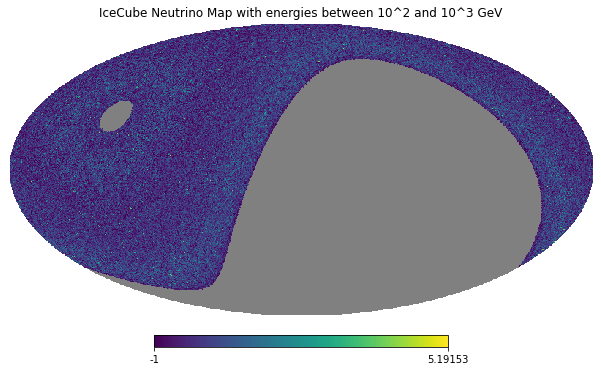

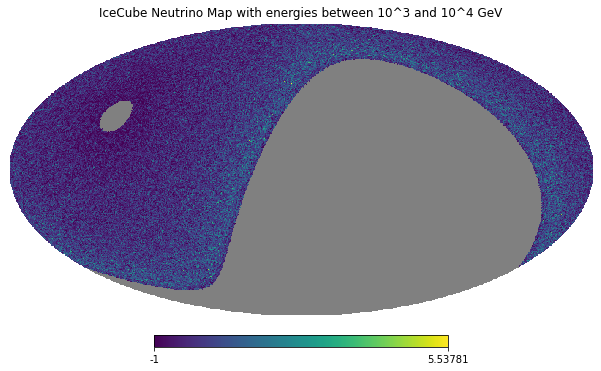

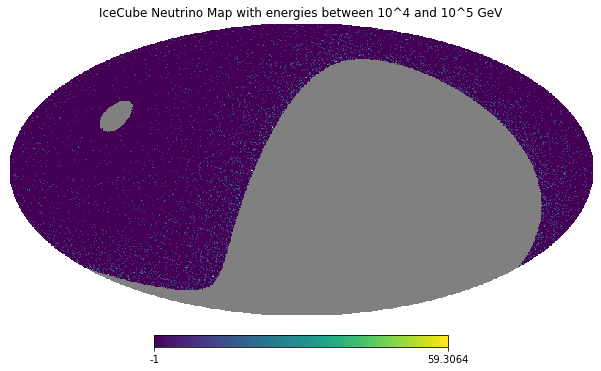

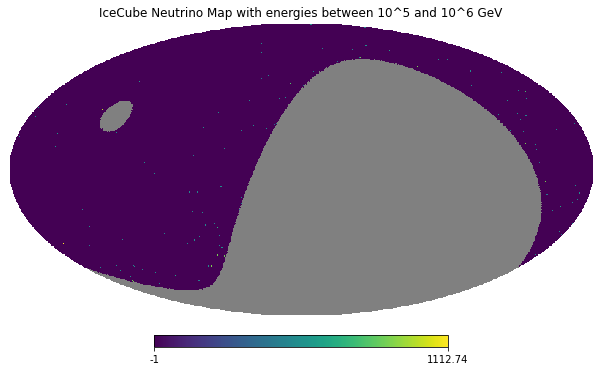

In [17]:
MapArray = [] #final array of neutrino event maps

#creates mask based on chosen minimum declination - 1 is unmasked, 0 masked
ICMask = np.ones(NPIX)
ConvertedDec = gal2equ(hp.pix2ang(NSIDE, np.arange(NPIX), lonlat = True), lonlat = True)[1]
ICMask[ConvertedDec < ICDecMin] = 0
        
#multiplies mask with weighted effective area masks to get overall mask for IceCube data
for i in range(len(ICEMapBands)):
    for j in range(len(ICAeffList)):
        ICMask *= WeightedAeffMask[i][j]

#a map is plotted for each energy band
for i in range(len(ICEMapBands)):

    #only keeps energies and declinations within energy band
    ICAllowedE = ICEventFull[np.logical_and(ICEMapBands[i][0] <= ICEventFull['log10(E/GeV)'], 
                                            ICEventFull['log10(E/GeV)'] < ICEMapBands[i][1])]
    ICEMapData = ICAllowedE[np.where(ICDecMin < ICAllowedE['Dec[deg]'])]

    #converts angular coords to pixel numbers
    ICPixelNumbers = hp.ang2pix(NSIDE, equ2gal(ICEMapData['RA[deg]'], ICEMapData['Dec[deg]'], 
                                lonlat = True)[0], equ2gal(ICEMapData['RA[deg]'], ICEMapData['Dec[deg]'], 
                                lonlat = True)[1], lonlat = True)

    #builds map array in galactic coordinates
    MapArrayBuild = np.zeros(NPIX)
    for j in range(len(ICAeffList)):
        UsefulICPixNo = ICPixelNumbers[ICEMapData['Year'] == j]
        Increment = np.bincount(UsefulICPixNo, minlength = NPIX)[ICMask > 0]
        if UseAeffWeights == True:
            MapArrayBuild[ICMask > 0] += np.divide(Increment, WeightedAeffMap[i][j][ICMask > 0])
        else:
            MapArrayBuild[ICMask > 0] += Increment

    #divides map by normalisation to get units of number count
    if UseAeffWeights == True:
        MapArrayBuild /= NormWeightedAeffMap[i]
    
    #converts pixel counts to over/underdensities
    AvgICMapPix = np.sum(MapArrayBuild*ICMask)/np.sum(ICMask)
    MapArray.append((MapArrayBuild/AvgICMapPix - 1))
    
    #sets masked pixels
    MapArray[i][ICMask <= 0] = hp.UNSEEN

    #displays healpix map with masked values
    hp.mollview(hp.ma(MapArray[i]), 
                title=(f'IceCube Neutrino Map with energies between 10^{ICEMapBands[i][0]} ' + 
                       f'and 10^{ICEMapBands[i][1]} GeV'))
    #hp.graticule() #adds grid

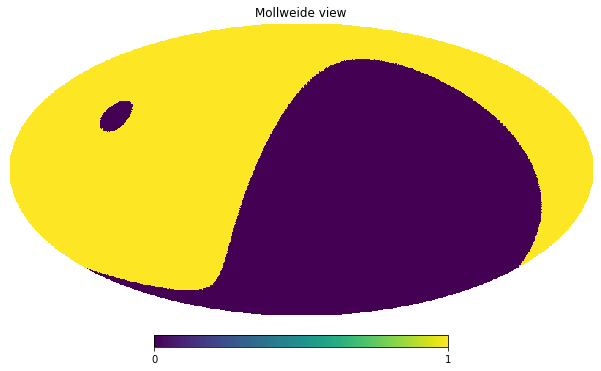

In [18]:
#displays neutrino event mask
hp.mollview(ICMask)

# Galaxy Maps

## Loading Data

In [19]:
#finds filenames of all galaxy map (and mask) files, sorted alphanumerically
GalMapAllFilenames = sorted(os.listdir(GalMapDir))

#differentiates the galaxy mask file from the galaxy map files
GalMapFilenames = []
for i in GalMapAllFilenames: #only appends files to lists if chosen keywords contained in filenames
    if GalMapKW in i:
        GalMapFilenames.append(i)
    elif GalMaskKW in i: #assumes one mask for all galaxy maps
        GalMaskFilename = i

In [20]:
#reads in galaxy maps
GalMapsOrigRes = []
for i in GalMapFilenames:
    GalMapsOrigRes.append(hp.read_map(GalMapDir + '/' + i))
    
#reads in galaxy mask
GalMaskOrigRes = hp.read_map(GalMapDir + '/' + GalMaskFilename)

## Plotting Maps

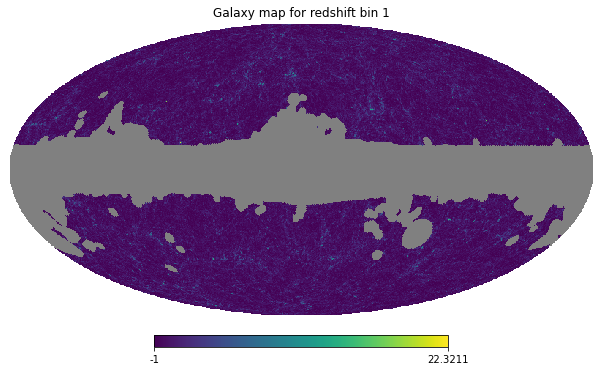

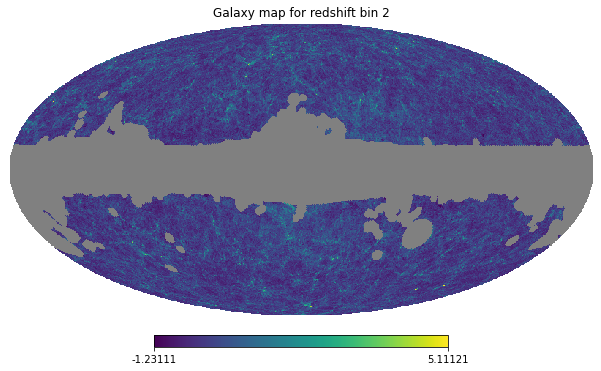

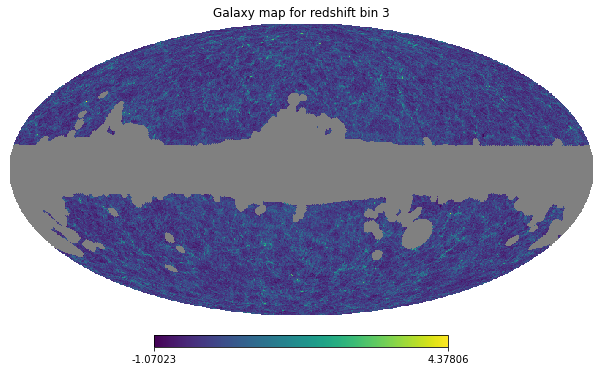

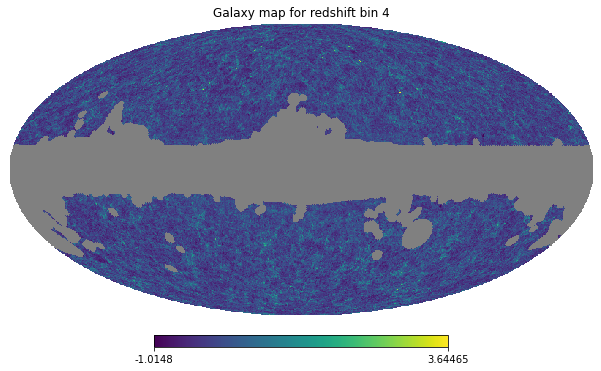

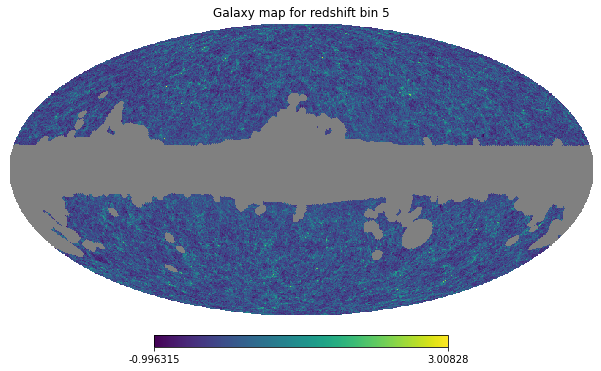

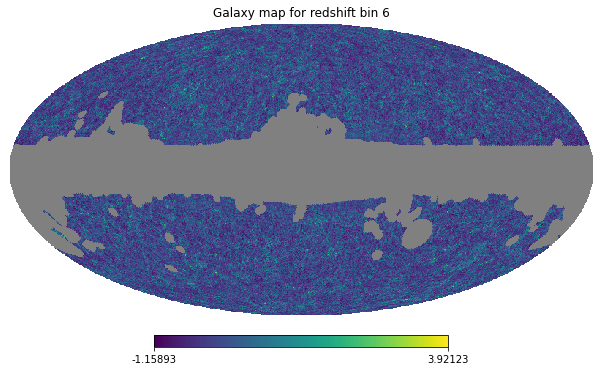

In [21]:
GalMaps = []

#changes galaxy mask NSIDE to match that of IceCube data
GalMask = hp.ud_grade(GalMaskOrigRes, NSIDE)

#fixes mask after NSIDE downgrade - averages of masked/unmasked pixels messes it up
GalMask[GalMask > 0.5] = 1
GalMask[GalMask <= 0.5] = 0
    

for i in range(len(GalMapsOrigRes)):
    
    #changes galaxy maps NSIDE to match that of IceCube data
    GalMaps.append(hp.ud_grade(GalMapsOrigRes[i], NSIDE))
    
    #sets masked pixels
    GalMaps[i][np.where(GalMask < 1)] = hp.UNSEEN
    
    #plots maps
    hp.mollview(hp.ma(GalMaps[i]), title = f'Galaxy map for redshift bin {i+1}')

# Angular Power Spectra

## IceCube Auto-correlation

### Equation Approximation

In [22]:
#finds largest l value given in alm coefficients
def alm2lvals(a_lm):
    #a_lm - alm coefficients to find the max l of. Length should always be a triangle number
    
    #finds number of different l values (lmax+1) from formula for triangle numbers
    lvalues = int(np.sqrt(2*len(a_lm)+0.25) - 1/2)
    
    return lvalues

In [23]:
#finds cl using equation from two arrays of a_lm coefficients
def find_cl_eqn(a_lm_1, a_lm_2, lval, fsky):
    #a_lm_1 - first set of a_lm coefficients (to be complex conjugated)
    #a_lm_2 - second set of a_lm coefficients
    #fsky - fraction of sky or which data available
    #lval - l value to find coefficient for
    #lengths of alm coefficient arrays must match
    
    #finds product of alms
    a_lm_prod = np.multiply(np.conj(a_lm_1), a_lm_2)
    
    #ensures l is integer
    lval = int(lval)
    
    #finds triangle number corresponding to l - sum starts on this index of a_lm_prod
    ltri = int((lval+1)*(lval/2))
    
    #sums all elements relating to l. m = 1,2,3... are counted twice to include negative m values
    alm_sum = np.sum(a_lm_prod[ltri:ltri+lval+1]) + np.sum(a_lm_prod[ltri+1:ltri+lval+1])

    #calculates cl coefficient
    c_l = alm_sum/(fsky*(2*lval+1))
    
    return c_l

    

In [24]:
IC_a_lm = []
IC_eqn_c_l = []

#calculates f_sky
ICf_sky = 1 - (np.sum(ICMask)/NPIX)

for i in range(len(MapArray)):
    #finds a_lm (spherical harmonic coefficients) and f_sky (fraction of sky unmasked) for each map
    IC_a_lm.append(hp.map2alm(MapArray[i])) #a_lm coefficients
    
    #finds c_l coefficients for each map
    IC_eqn_c_l.append([])
    for j in range(alm2lvals(IC_a_lm[i])): #loops through all l values
        IC_eqn_c_l[i].append(find_cl_eqn(IC_a_lm[i], IC_a_lm[i], j, ICf_sky))


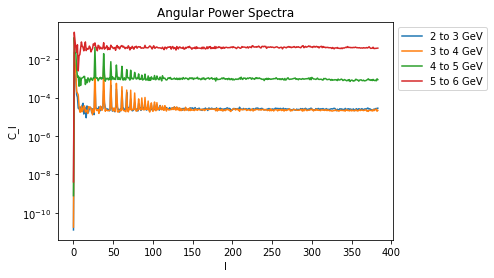

In [25]:
#plots angular power spectra for each energy bin
plt.yscale('log')
for i in range(len(MapArray)):
    plt.plot(np.arange(0,len(IC_eqn_c_l[i])), np.abs(IC_eqn_c_l[i]), 
             label = f'{ICEMapBands[i][0]} to {ICEMapBands[i][1]} GeV')
plt.title('Angular Power Spectra')
plt.xlabel('l')
plt.ylabel('C_l')
plt.legend(bbox_to_anchor = (1, 1))
plt.show()

### Healpy Approximation

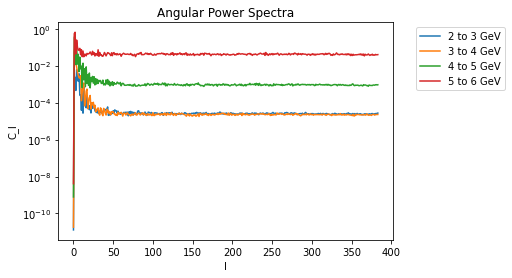

In [26]:
#uses healpy function anafast to approximate c_l values
ICHealpyCl = []
for i in MapArray:
    ICHealpyCl.append(hp.anafast(i)/ICf_sky)

#plots angular power spectra from these c_l values
plt.yscale('log')
for i in range(len(MapArray)):
    plt.plot(np.arange(0,len(ICHealpyCl[i])), ICHealpyCl[i], 
             label = f'{ICEMapBands[i][0]} to {ICEMapBands[i][1]} GeV')
plt.title('Angular Power Spectra')
plt.xlabel('l')
plt.ylabel('C_l')
plt.legend(bbox_to_anchor = (1.35, 1))
plt.show()

### NaMaster Approximation

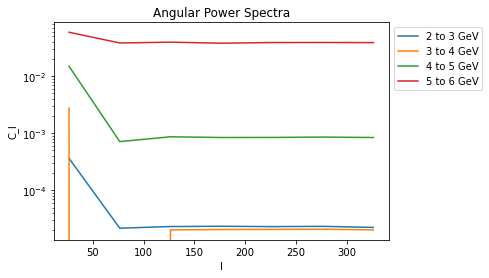

In [27]:
MapArrayField = []
ICNmt_cl = []
ICw = []

#initialise binning scheme with LPerBP l values per bandpower
b = nmt.NmtBin.from_nside_linear(NSIDE, LPerBP)
#finds weighted average l value for each bandpower
l_avg = b.get_effective_ells()
#creates workspace
ICw = nmt.NmtWorkspace()
ICf = nmt.NmtField(ICMask, None, spin=0)
ICw.compute_coupling_matrix(ICf, ICf, b)

for i in range(len(MapArray)):

    #initialises maps as fields
    MapArrayField.append(nmt.NmtField(ICMask, [MapArray[i]]))
    
    #computes cls
    ICNmt_cl.append(ICw.decouple_cell(nmt.compute_coupled_cell(MapArrayField[i], MapArrayField[i]))[0])
    
    #plots angular power spectra for this energy bin
    plt.plot(l_avg, ICNmt_cl[i], label = f'{ICEMapBands[i][0]} to {ICEMapBands[i][1]} GeV')

#plot formatting
plt.yscale('log')
plt.title('Angular Power Spectra')
plt.xlabel('l')
plt.ylabel('C_l')
plt.legend(bbox_to_anchor = (1, 1))
plt.show()

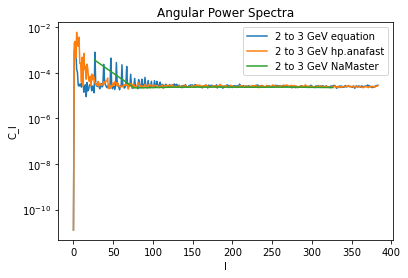

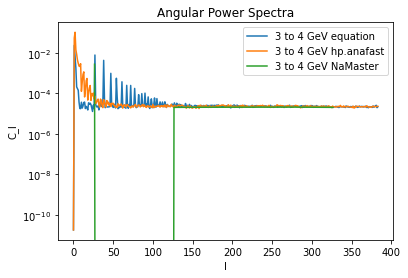

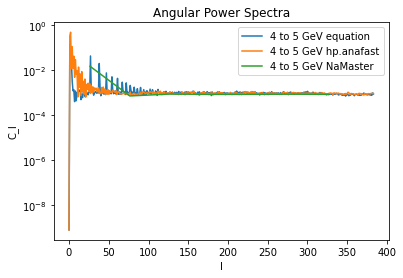

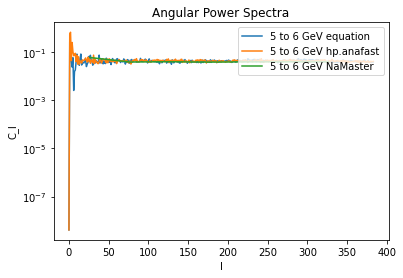

In [28]:
#plots all methods on same figure for each energy bin
for i in range(len(MapArray)):
    plt.plot(np.arange(0,len(IC_eqn_c_l[i])), np.abs(IC_eqn_c_l[i]), 
             label = f'{ICEMapBands[i][0]} to {ICEMapBands[i][1]} GeV equation')
    plt.plot(np.arange(0,len(ICHealpyCl[i])), ICHealpyCl[i],
             label = f'{ICEMapBands[i][0]} to {ICEMapBands[i][1]} GeV hp.anafast')
    plt.plot(l_avg, ICNmt_cl[i], label = f'{ICEMapBands[i][0]} to {ICEMapBands[i][1]} GeV NaMaster')
    
    #plot formatting
    plt.yscale('log')
    plt.title('Angular Power Spectra')
    plt.xlabel('l')
    plt.ylabel('C_l')
    plt.legend(loc='upper right')
    plt.show()

### Jackknife Error Functions

In [29]:
def get_regions(mask, n_regions, unassigned=hp.UNSEEN):
    """ Generates `n_regions` regions of roughly equal area
    for a given sky mask `mask`, assuming HEALPix "RING"
    ordering. Returns a HEALPix map where each pixel holds
    the index of the region it is assigned to. Unassigned
    pixels will take the `unassigned` value.
    """
    npix = len(mask)
    nside = hp.npix2nside(npix)
    ipix = np.arange(npix)
    ra, dec = hp.pix2ang(nside, ipix, lonlat=True)
    goodpix = mask > 0
    km = kmeans_sample(np.array([ra[goodpix], dec[goodpix]]).T,
                       n_regions, maxiter=100, tol=1.0e-5,
                       verbose=False)
    map_ids = np.full(npix, unassigned)
    map_ids[ipix[goodpix]] = km.labels
    return map_ids

In [30]:
#generates jackknife masks
def get_jknife_msk(mask, njknife):
    # jackknife regions
    regions = get_regions(mask, njknife, unassigned=hp.UNSEEN)
    # Option 1
    mskjknife = np.array([(regions != i).astype(float)*mask for i in range(njknife)])
    return mskjknife

In [31]:
#calculates jackknife covariance matrix using np.cov
def np_jknife_cov(JKC_ls, njknife):
    
    C_lerrs = (njknife - 1) * np.cov(JKC_ls, rowvar = False, ddof = 0)
    
    return C_lerrs
    
    

In [32]:
#calculates jackknife covariance matrix manually - not used but gives same result
def get_jknife_cov(JKC_ls, njknife):
    #JKC_ls - list of arrays of C_ls to compute errors for
    #njknife - number of jackknife regions
    
    C_lerrs = []
    
    #prefactor for error calculation
    SumPrefactor = (njknife - 1)/njknife
    
    for i in range(len(JKC_ls[0])): #loops over integer ls
        
        C_lerrs.append([])
        
        C_l = [] #holds C_l elements for current sum
        
        for j in range(len(JKC_ls)): #loops over jackknife masks
            C_l.append(JKC_ls[j][i])
        
        #finds mean C_l of jackknife masks for this integer l
        MeanC_l = np.sum(C_l)/len(C_l)
        
        for j in range(len(JKC_ls[0])): #loops over l primes
            
            C_lprime = [] #holds C_l prime elements for current sum
            
            for k in range(len(JKC_ls)): #loops over jackknife masks
                C_lprime.append(JKC_ls[k][j])
        
            #finds mean C_l prime of jackknife masks for this integer l
            MeanC_lprime = np.sum(C_lprime)/len(C_lprime)
            
            #finds sum total in error calculation
            C_lSumTot = np.sum((np.array(C_l) - MeanC_l)*(np.array(C_lprime) - MeanC_lprime))

            #finds error for this integer l
            C_lerrs[i].append(SumPrefactor*C_lSumTot)

    return C_lerrs

In [33]:
def get_JK_cls(mask, maps1, maps2, njknife, cross = False):
    #mask - mask to use
    #maps1 - first set of maps to compute cls for
    #maps2 - second set of maps to compute cls for
    #njknife - number of regions for jackknife resampling
    #cross - whether auto or cross correlation
    
    JKNmt_w = []
    JKNmt_cl = []
    
    #finds jackknife masks
    JKMasks = get_jknife_msk(mask, njknife)
    
    #progress bar
    print('Jackknife masks generated.')
    
    for i in range(njknife): #loops over jknife masks
        
        JKNmt_cl.append([])
        
        #creates workspace
        JKNmt_w.append(nmt.NmtWorkspace())
        JKNmt_f = nmt.NmtField(JKMasks[i], None, spin=0)
        JKNmt_w[i].compute_coupling_matrix(JKNmt_f, JKNmt_f, b)
        
        if cross == False: #if auto-correlation
            
            for j in range(len(maps1)):
                
                #initialises map
                JKField1 = nmt.NmtField(JKMasks[i], [maps1[j]])
                
                #compute cls
                JKNmt_cl[i].append(JKNmt_w[i].decouple_cell(nmt.compute_coupled_cell(JKField1, 
                                                                                     JKField1))[0])
        
        else: #if cross-correlation
            
            for j in range(len(maps1)):
                
                #initialises first field
                JKField1 = nmt.NmtField(JKMasks[i], [maps1[j]])
                JKNmt_cl[i].append([])
                
                for k in range(len(maps2)):
                    
                    #initialises second field
                    JKField2 = nmt.NmtField(JKMasks[i], [maps2[k]])
                    
                    #computes cls
                    JKNmt_cl[i][j].append(JKNmt_w[i].decouple_cell(nmt.compute_coupled_cell(JKField1, 
                                                                                         JKField2))[0])
        
        #progress bar
        if (i+1)%10 == 0:
            print(f'JK Mask {i+1} out of {njknife} done.')
        
    return JKNmt_cl

### Jackknife Errors

In [34]:
if ImportJKcls == False:
    #gets cls - takes a while
    ICJKNmt_cl = np.swapaxes(get_JK_cls(ICMask, MapArray, MapArray, JKRegions), 0, 1)
    
    with open(ImportJKclsPath + '/ICJKNmt_cl', 'wb') as fp:   #saves JKcls
        pickle.dump(ICJKNmt_cl, fp)
    
else:
    with open(ImportJKclsPath + '/ICJKNmt_cl', 'rb') as fp:   #imports JKcls
        ICJKNmt_cl = pickle.load(fp)

Jackknife masks generated.
JK Mask 10 out of 100 done.
JK Mask 20 out of 100 done.
JK Mask 30 out of 100 done.
JK Mask 40 out of 100 done.
JK Mask 50 out of 100 done.
JK Mask 60 out of 100 done.
JK Mask 70 out of 100 done.
JK Mask 80 out of 100 done.
JK Mask 90 out of 100 done.
JK Mask 100 out of 100 done.


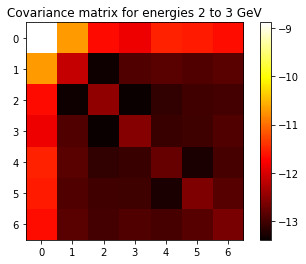

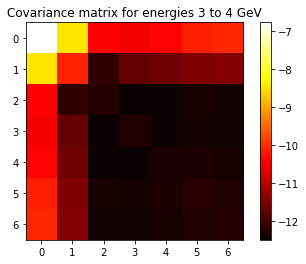

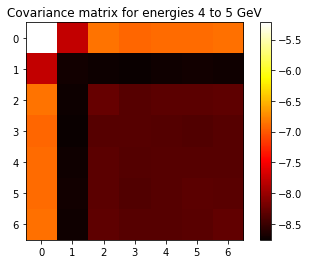

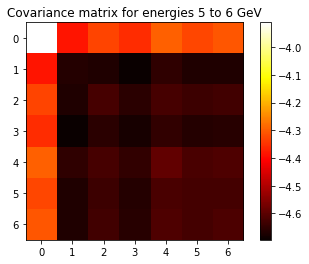

In [35]:
ICJKNmt_cl_cov = []
for i in range(len(MapArray)):
    
    #gets cl covariance matrix for each map
    ICJKNmt_cl_cov.append(np_jknife_cov(ICJKNmt_cl[i], JKRegions))
    
    #plots covariance matrix for each map
    plt.imshow(np.log10(np.abs(ICJKNmt_cl_cov[i])), cmap = 'hot', interpolation = 'nearest')
    plt.title(f'Covariance matrix for energies {ICEMapBands[i][0]} to {ICEMapBands[i][1]} GeV')
    plt.colorbar()
    plt.show()

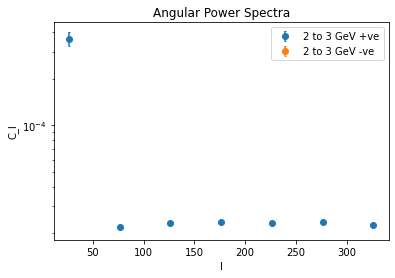

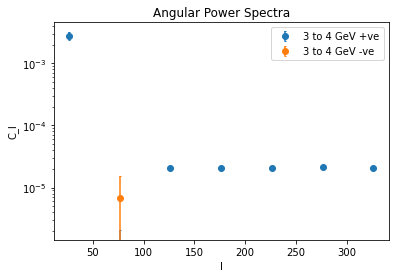

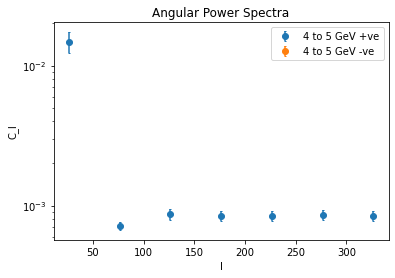

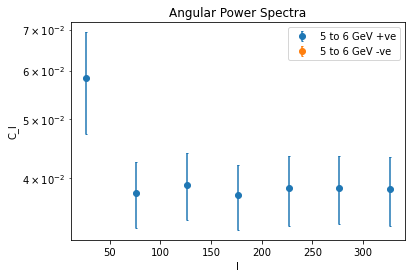

In [36]:
ICJKNmt_cl_err = []
for i in range(len(MapArray)):
    #extracts diagonal elements from the covariance matrix to use as errors
    ICJKNmt_cl_err.append(np.sqrt(np.diag(ICJKNmt_cl_cov[i])))
     
    #plots error bars on angular power spectra
    plt.errorbar(l_avg, ICNmt_cl[i], yerr = ICJKNmt_cl_err[i], capsize = 1, fmt = 'o',
                 label = f'{ICEMapBands[i][0]} to {ICEMapBands[i][1]} GeV +ve')
    plt.errorbar(l_avg, -ICNmt_cl[i], yerr = ICJKNmt_cl_err[i], capsize = 1, fmt = 'o',
                     label = f'{ICEMapBands[i][0]} to {ICEMapBands[i][1]} GeV -ve')
    
    #plot formatting
    plt.yscale('log')
    plt.title('Angular Power Spectra')
    plt.xlabel('l')
    plt.ylabel('C_l')
    plt.legend(bbox_to_anchor = (1, 1))
    plt.show()

In [37]:
#finds the indices above lmin
lminind = np.where(l_avg >= lmin)

#finds null hypothesis from jackknife errors for each energy bin
ICJKNullHyp = 0
for i in range(len(MapArray)):
    ICJKNullHyp += np.sum(np.array(ICNmt_cl[i][lminind])**2/(2*(ICJKNmt_cl_err[i][lminind])**2))
    
print(f'Null hypothesis for IC auto-correlation: {ICJKNullHyp}')

Null hypothesis for IC auto-correlation: 8716.548743855905


## Galaxy Auto-correlation

### NaMaster Approximation

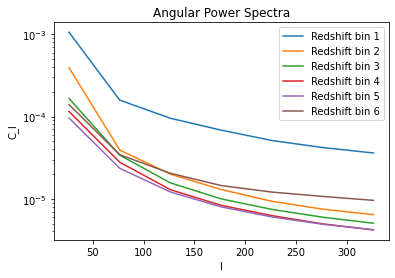

In [38]:
GalMapsField = []
GalNmt_cl = []

#creates workspace
Galw = nmt.NmtWorkspace()
Galf = nmt.NmtField(GalMask, None, spin=0)
Galw.compute_coupling_matrix(Galf, Galf, b)

for i in range(len(GalMaps)):

    #initialises maps as fields
    GalMapsField.append(nmt.NmtField(GalMask, [GalMaps[i]]))
    
    #computes cls
    GalNmt_cl.append(Galw.decouple_cell(nmt.compute_coupled_cell(GalMapsField[i], GalMapsField[i]))[0])
    
    #plots angular power spectra for this redshift bin
    plt.plot(l_avg, GalNmt_cl[i], label = f'Redshift bin {i+1}')

#plot formatting
plt.yscale('log')
plt.title('Angular Power Spectra')
plt.xlabel('l')
plt.ylabel('C_l')
plt.legend(bbox_to_anchor = (1, 1))
plt.show()

### Jackknife Errors

In [39]:
if ImportJKcls == False:
    #gets cls - takes a while
    GalJKNmt_cl = np.swapaxes(get_JK_cls(GalMask, GalMaps, GalMaps, JKRegions), 0, 1)
    
    with open(ImportJKclsPath + '/GalJKNmt_cl', 'wb') as fp:   #saves JKcls
        pickle.dump(GalJKNmt_cl, fp)
    
else:
    with open(ImportJKclsPath + '/GalJKNmt_cl', 'rb') as fp:   #imports JKcls
        GalJKNmt_cl = pickle.load(fp)

Jackknife masks generated.
JK Mask 10 out of 100 done.
JK Mask 20 out of 100 done.
JK Mask 30 out of 100 done.
JK Mask 40 out of 100 done.
JK Mask 50 out of 100 done.
JK Mask 60 out of 100 done.
JK Mask 70 out of 100 done.
JK Mask 80 out of 100 done.
JK Mask 90 out of 100 done.
JK Mask 100 out of 100 done.


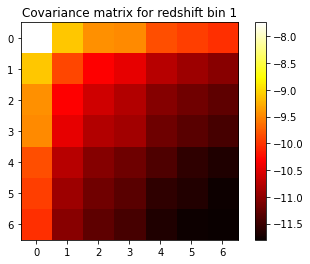

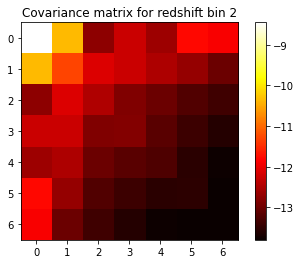

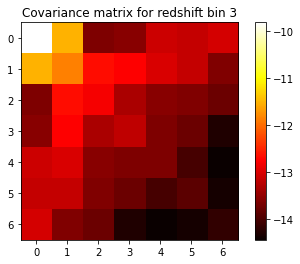

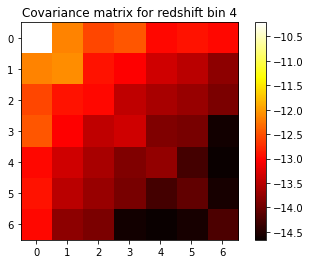

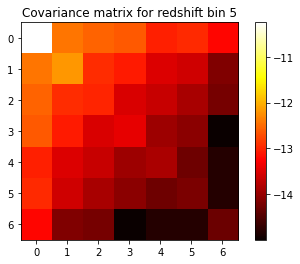

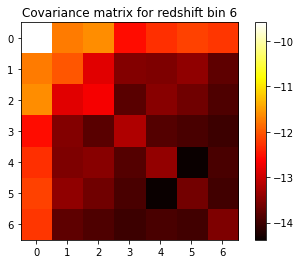

In [40]:
GalJKNmt_cl_cov = []
for i in range(len(GalMaps)):
    
    #gets cl covariance matrix for each map
    GalJKNmt_cl_cov.append(np_jknife_cov(GalJKNmt_cl[i], JKRegions))
    
    #plots covariance matrix for each map
    plt.imshow(np.log10(np.abs(GalJKNmt_cl_cov[i])), cmap = 'hot', interpolation = 'nearest')
    plt.title(f'Covariance matrix for redshift bin {i+1}')
    plt.colorbar()
    plt.show()

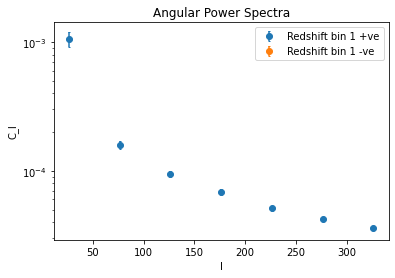

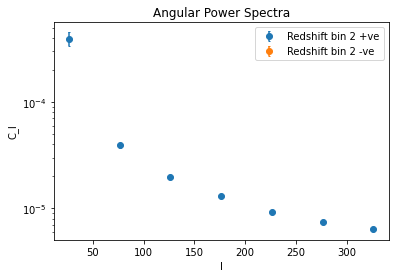

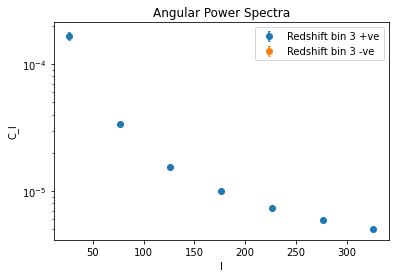

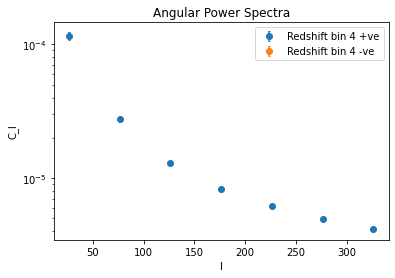

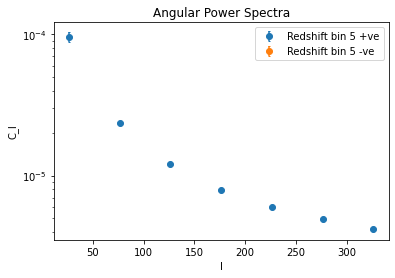

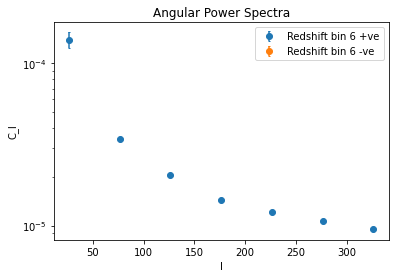

In [41]:
GalJKNmt_cl_err = []
for i in range(len(GalMaps)):
    #extracts diagonal elements from the covariance matrix to use as errors
    GalJKNmt_cl_err.append(np.sqrt(np.diag(GalJKNmt_cl_cov[i])))
    
    #plots error bars on angular power spectra
    plt.errorbar(l_avg, GalNmt_cl[i], yerr = GalJKNmt_cl_err[i], capsize = 1, fmt = 'o',
                 label = f'Redshift bin {i+1} +ve')
    plt.errorbar(l_avg, -GalNmt_cl[i], yerr = GalJKNmt_cl_err[i], capsize = 1, fmt = 'o',
                     label = f'Redshift bin {i+1} -ve')
    
    #plot formatting
    plt.yscale('log')
    plt.title('Angular Power Spectra')
    plt.xlabel('l')
    plt.ylabel('C_l')
    plt.legend(bbox_to_anchor = (1, 1))
    plt.show()

In [42]:
#finds null hypothesis from jackknife errors for each energy bin
GalJKNullHyp = []
for i in range(len(GalMaps)):
    GalJKNullHyp.append(np.sum(np.array(GalNmt_cl[i][lminind])**2/(2*(GalJKNmt_cl_err[i][lminind])**2)))
    
    print(f'Null hypothesis for redshift bin {i+1}: {GalJKNullHyp[i]}')

Null hypothesis for redshift bin 1: 1579.544114600173
Null hypothesis for redshift bin 2: 4216.286284223916
Null hypothesis for redshift bin 3: 6231.634454764835
Null hypothesis for redshift bin 4: 6082.4541554686575
Null hypothesis for redshift bin 5: 6916.3915383723715
Null hypothesis for redshift bin 6: 9062.379995705343


## Cross-correlation

### NaMaster Approximation

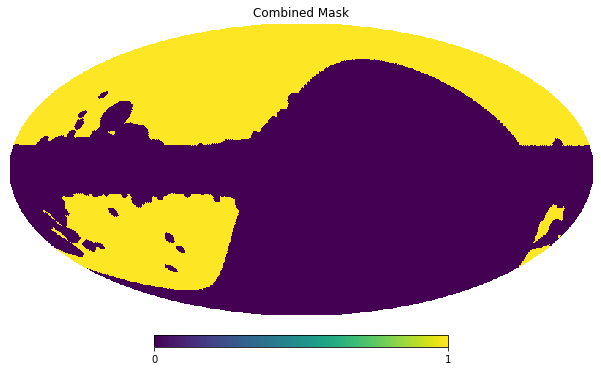

In [43]:
#creates combined masks of IceCube data and galaxy maps
CrossMask = np.multiply(ICMask, GalMask)
#shows combined mask
hp.mollview(CrossMask, title = 'Combined Mask')

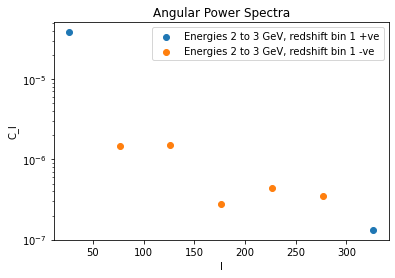

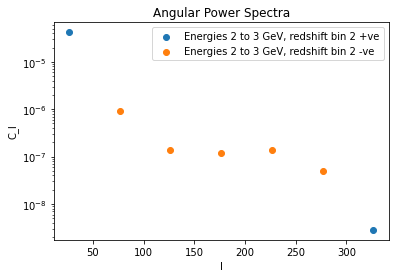

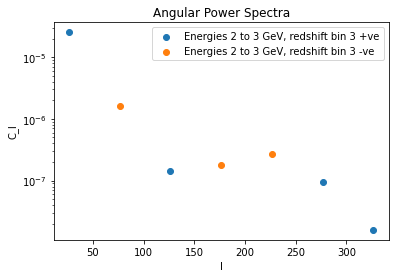

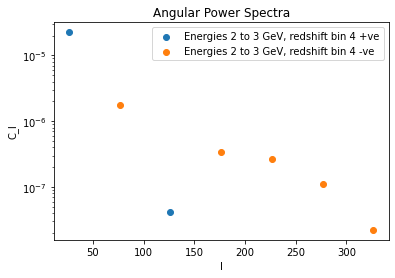

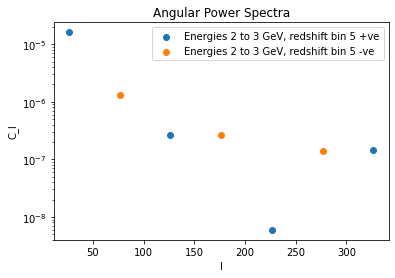

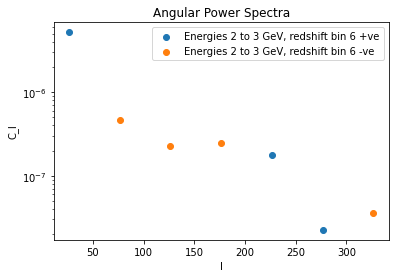

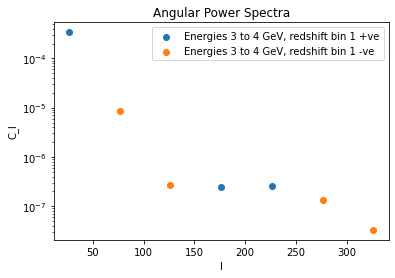

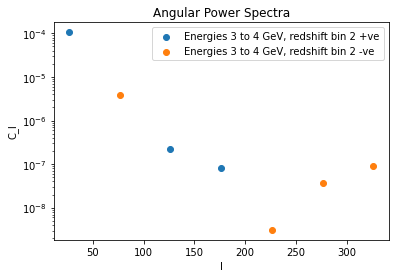

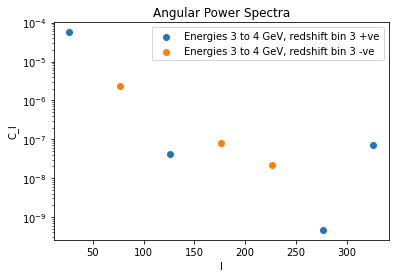

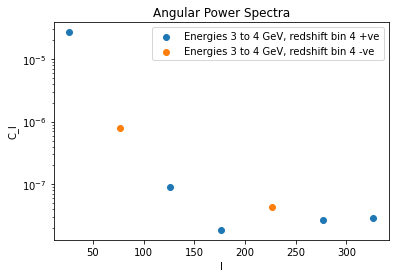

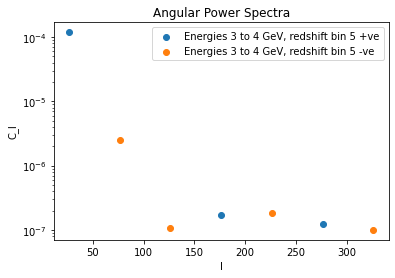

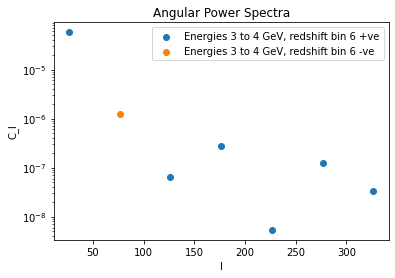

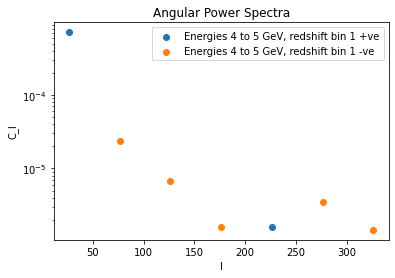

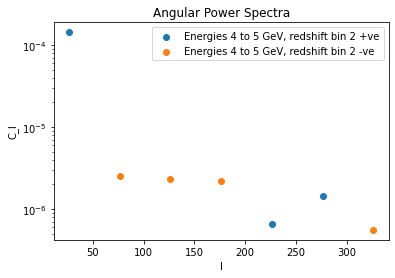

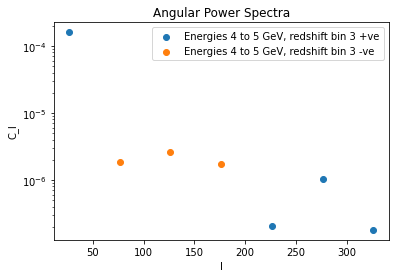

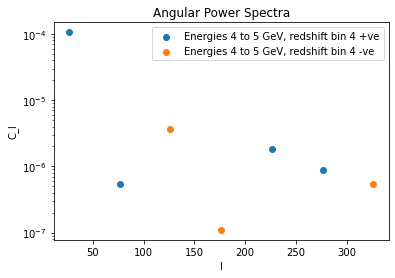

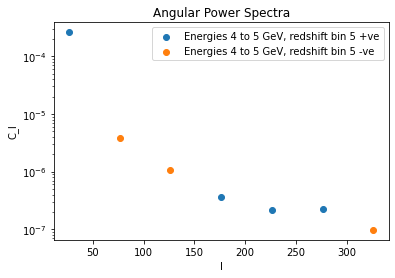

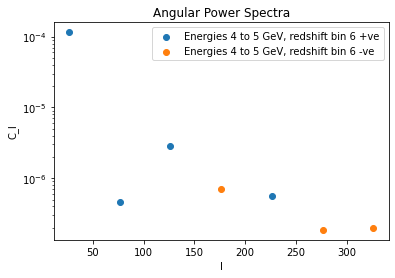

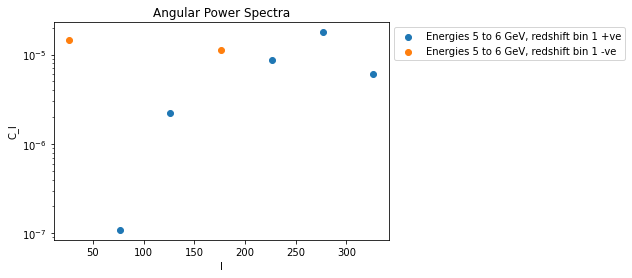

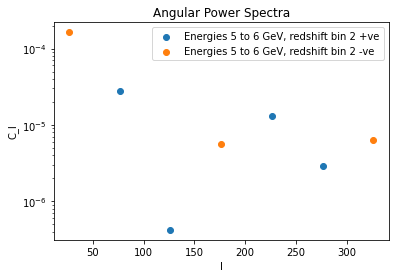

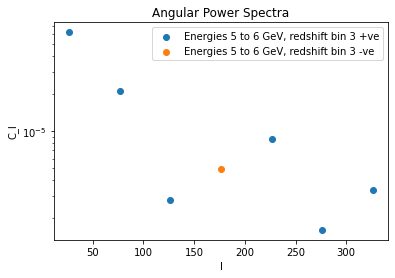

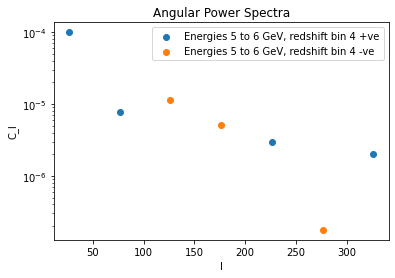

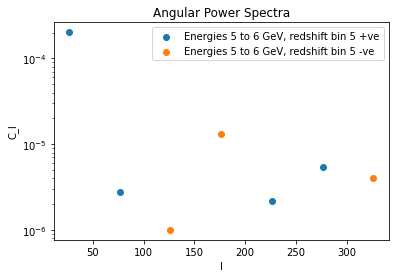

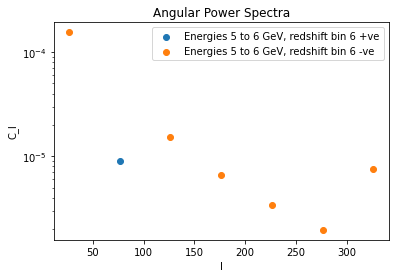

In [44]:
CrossNmt_cl = []
CrossMapArrayField = []
CrossGalMapsField = []

#creates workspace
Crossw = nmt.NmtWorkspace()
Crossf = nmt.NmtField(CrossMask, None, spin=0)
Crossw.compute_coupling_matrix(Crossf, Crossf, b)

for i in range(len(MapArray)): #loops over neutrino energy bins
    
    CrossNmt_cl.append([])
    
    #initialises IceCube fields
    CrossMapArrayField.append(nmt.NmtField(CrossMask, [MapArray[i]]))
    
    for j in range(len(GalMaps)): #loops over galaxy redshift bins
        
        #initialises galaxy fields
        CrossGalMapsField.append(nmt.NmtField(CrossMask, [GalMaps[j]]))
    
        #computes cross cls
        CrossNmt_cl[i].append(Crossw.decouple_cell(nmt.compute_coupled_cell(CrossMapArrayField[i], 
                                                                          CrossGalMapsField[j]))[0])
        
        #plots angular power spectra for this redshift bin
        plt.scatter(l_avg, CrossNmt_cl[i][j],
                 label = f'Energies {ICEMapBands[i][0]} to {ICEMapBands[i][1]} GeV, redshift bin {j+1} +ve')
        plt.scatter(l_avg, -CrossNmt_cl[i][j],
                 label = f'Energies {ICEMapBands[i][0]} to {ICEMapBands[i][1]} GeV, redshift bin {j+1} -ve')

        #plot formatting
        plt.yscale('log')
        plt.title('Angular Power Spectra')
        plt.xlabel('l')
        plt.ylabel('C_l')
        plt.legend(bbox_to_anchor = (1, 1))
        plt.show()


### Jackknife Errors

In [45]:
if ImportJKcls == False:
    #gets cls - takes a long while
    CrossJKNmt_cl = np.swapaxes(get_JK_cls(CrossMask, GalMaps, MapArray, 
                                            JKRegions, cross = True), 0, 2)
    
    with open(ImportJKclsPath + '/CrossJKNmt_cl', 'wb') as fp:   #saves JKcls
        pickle.dump(CrossJKNmt_cl, fp)
    
else:
    with open(ImportJKclsPath + '/CrossJKNmt_cl', 'rb') as fp:   #imports JKcls
        CrossJKNmt_cl = pickle.load(fp)

Jackknife masks generated.
JK Mask 10 out of 100 done.
JK Mask 20 out of 100 done.
JK Mask 30 out of 100 done.
JK Mask 40 out of 100 done.
JK Mask 50 out of 100 done.
JK Mask 60 out of 100 done.
JK Mask 70 out of 100 done.
JK Mask 80 out of 100 done.
JK Mask 90 out of 100 done.
JK Mask 100 out of 100 done.


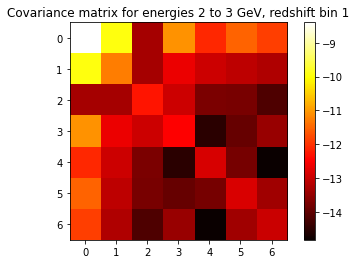

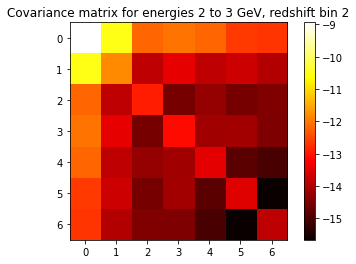

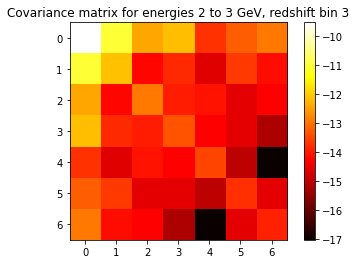

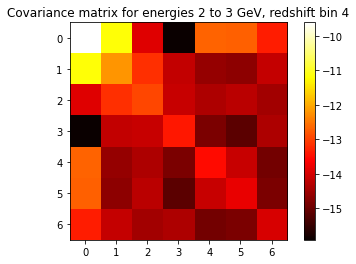

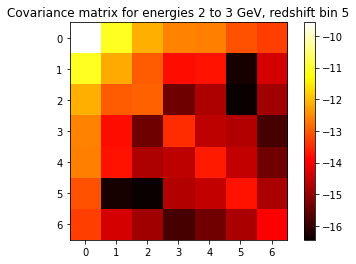

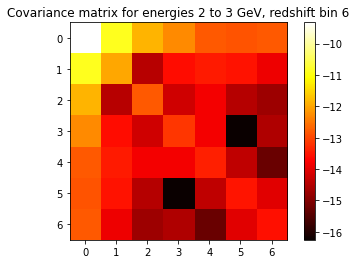

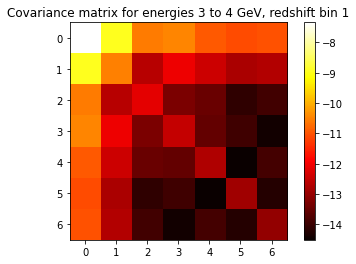

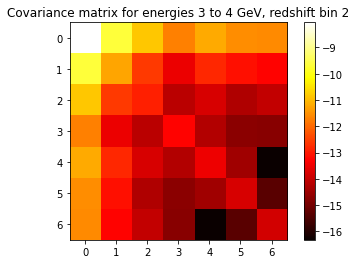

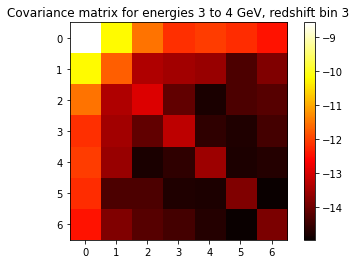

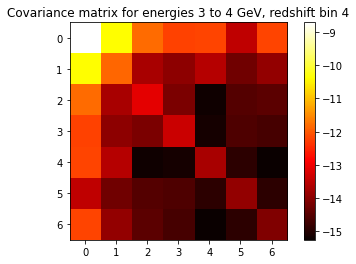

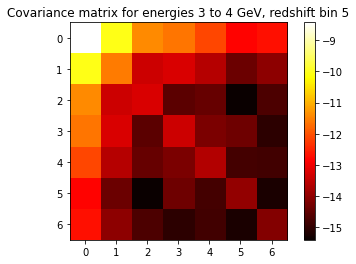

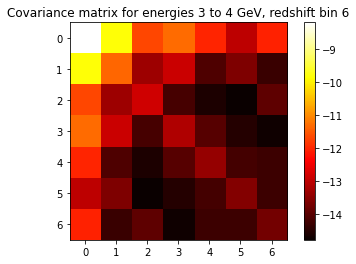

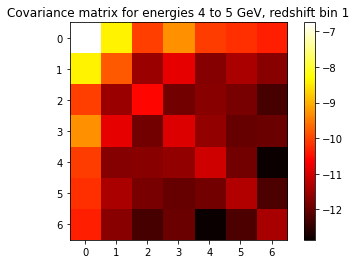

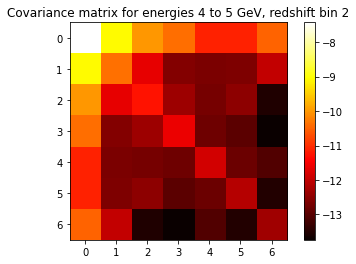

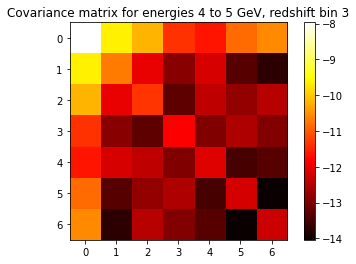

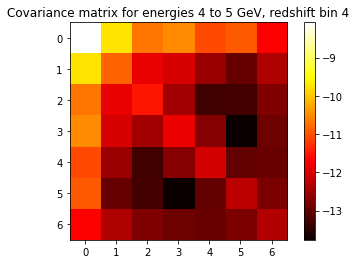

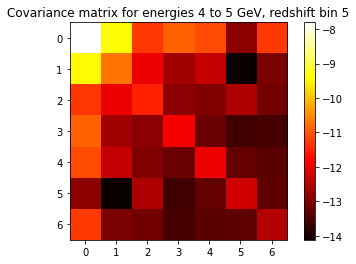

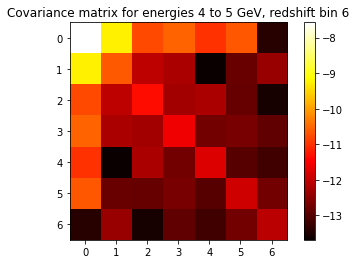

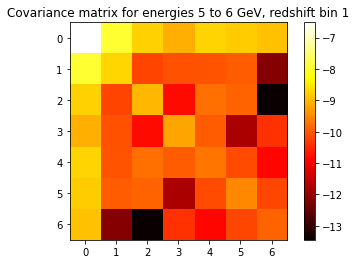

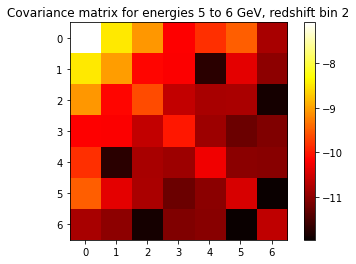

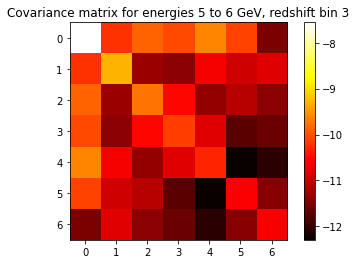

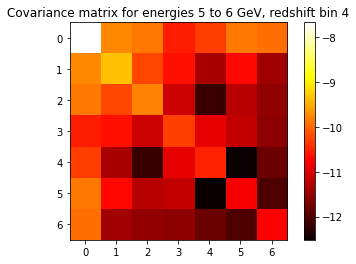

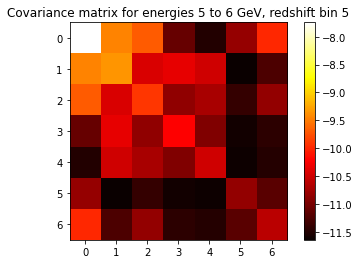

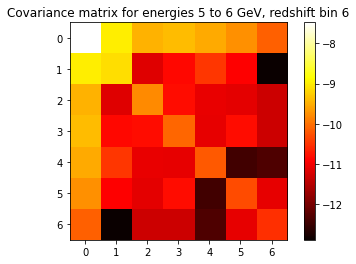

In [46]:
CrossJKNmt_cl_cov = []
for i in range(len(MapArray)): #loops over energy bins
    
    CrossJKNmt_cl_cov.append([])
    
    for j in range(len(GalMaps)): #loops over redshift bins
    
        #gets cl covariance matrix for each map
        CrossJKNmt_cl_cov[i].append(np_jknife_cov(CrossJKNmt_cl[i][j], JKRegions))

        #plots covariance matrix for each map
        plt.imshow(np.log10(np.abs(CrossJKNmt_cl_cov[i][j])), cmap = 'hot', interpolation = 'nearest')
        plt.title(f'Covariance matrix for energies {ICEMapBands[i][0]} to {ICEMapBands[i][1]} GeV,' +
                  f' redshift bin {j+1}')
        plt.colorbar()
        plt.show()

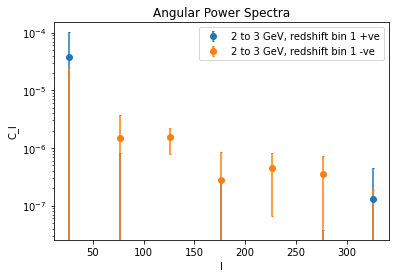

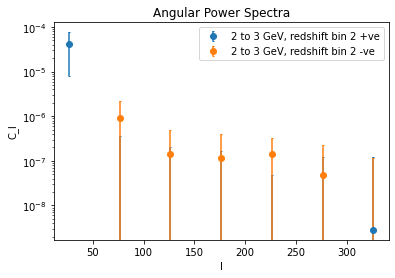

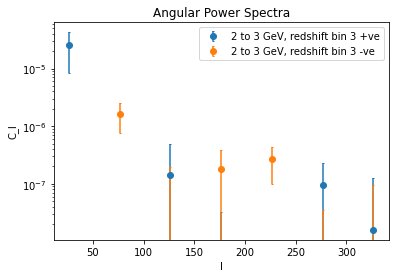

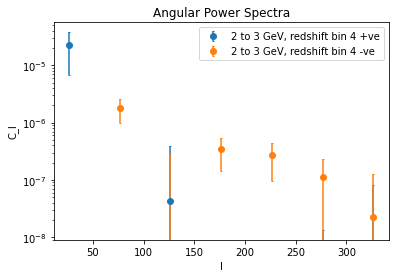

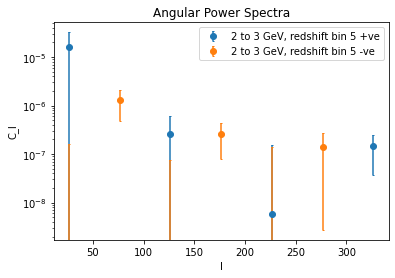

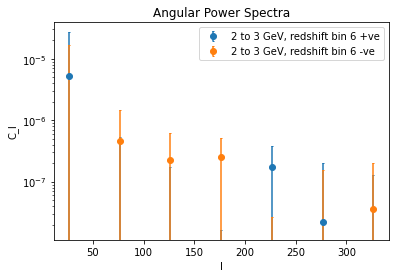

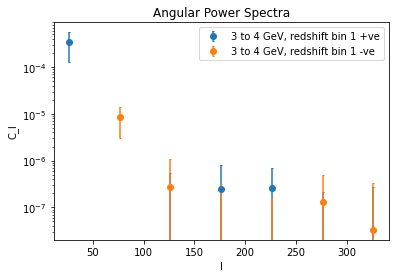

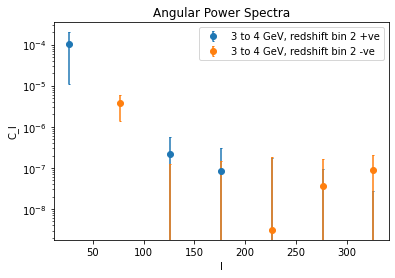

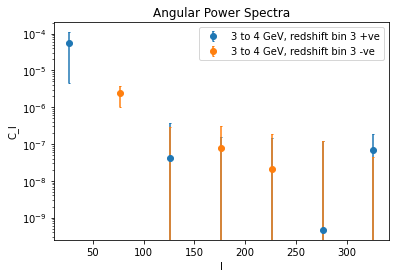

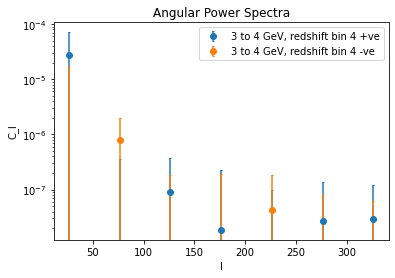

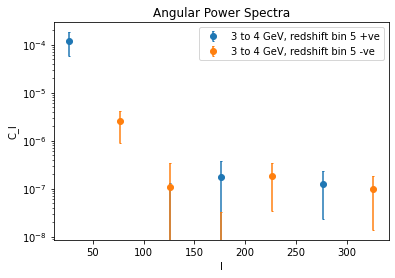

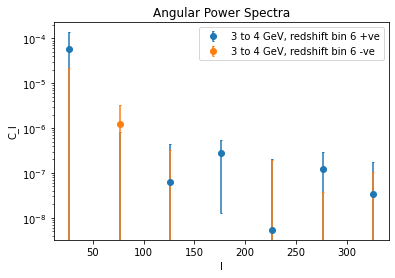

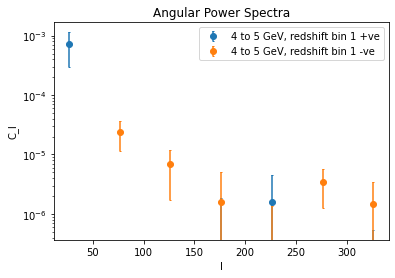

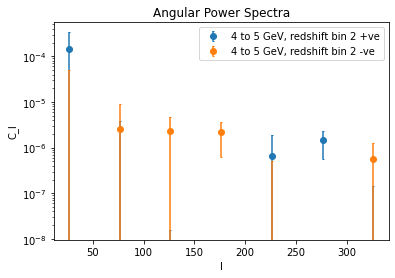

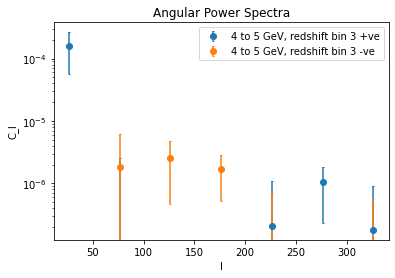

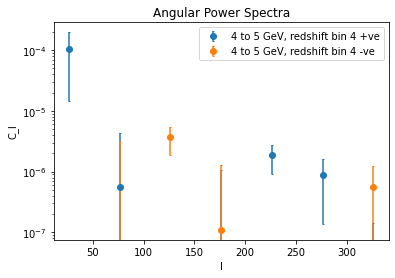

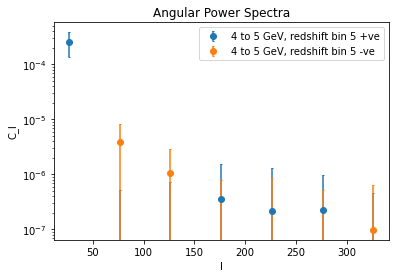

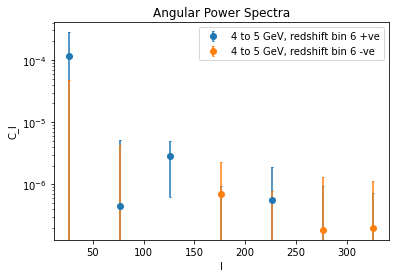

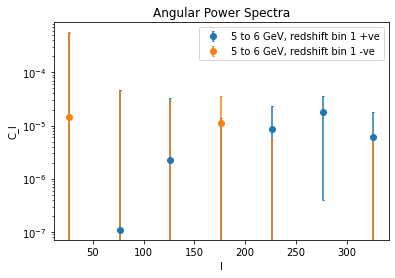

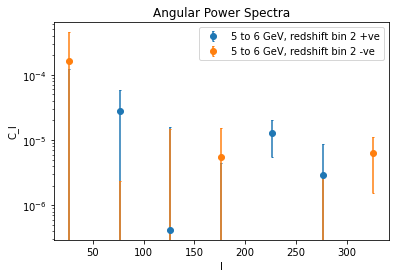

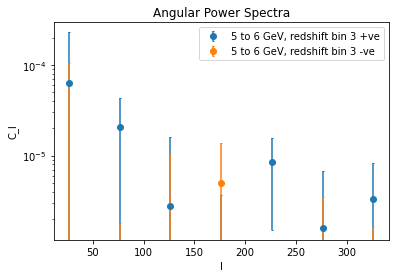

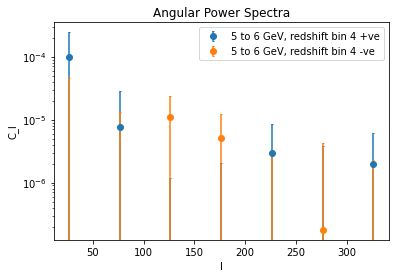

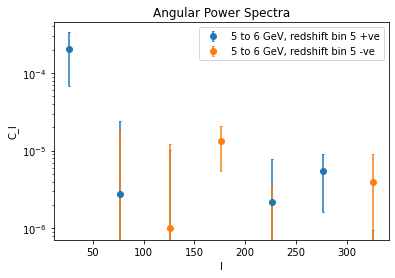

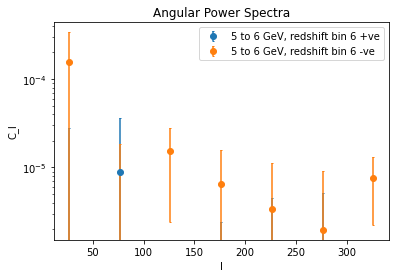

In [47]:
CrossJKNmt_cl_err = []

for i in range(len(MapArray)):
    
    CrossJKNmt_cl_err.append([])
    
    for j in range(len(GalMaps)):
        #extracts diagonal elements from the covariance matrix to use as errors
        CrossJKNmt_cl_err[i].append(np.sqrt(np.diag(CrossJKNmt_cl_cov[i][j])))

        #plots error bars on angular power spectra
        plt.errorbar(l_avg, CrossNmt_cl[i][j], yerr = CrossJKNmt_cl_err[i][j], capsize = 1, fmt = 'o',
                     label = f'{ICEMapBands[i][0]} to {ICEMapBands[i][1]} GeV, redshift bin {j+1} +ve')
        plt.errorbar(l_avg, -CrossNmt_cl[i][j], yerr = CrossJKNmt_cl_err[i][j], capsize = 1, fmt = 'o',
                     label = f'{ICEMapBands[i][0]} to {ICEMapBands[i][1]} GeV, redshift bin {j+1} -ve')

        #plot formatting
        plt.yscale('log')
        plt.title('Angular Power Spectra')
        plt.xlabel('l')
        plt.ylabel('C_l')
        plt.legend(bbox_to_anchor = (1, 1))
        plt.show()

In [48]:
#loads in cls calculated by David
if ICDataset == 10:
    with open('David_cls_all', 'rb') as fp:   #loads cls_all
            cls_all = pickle.load(fp)

    with open('David_cl_errors', 'rb') as fp:   #loads cl_errors
            cl_errors = pickle.load(fp)
            
    with open('David_cls_jk', 'rb') as fp:   #loads cls_jk
            cls_jk = pickle.load(fp)

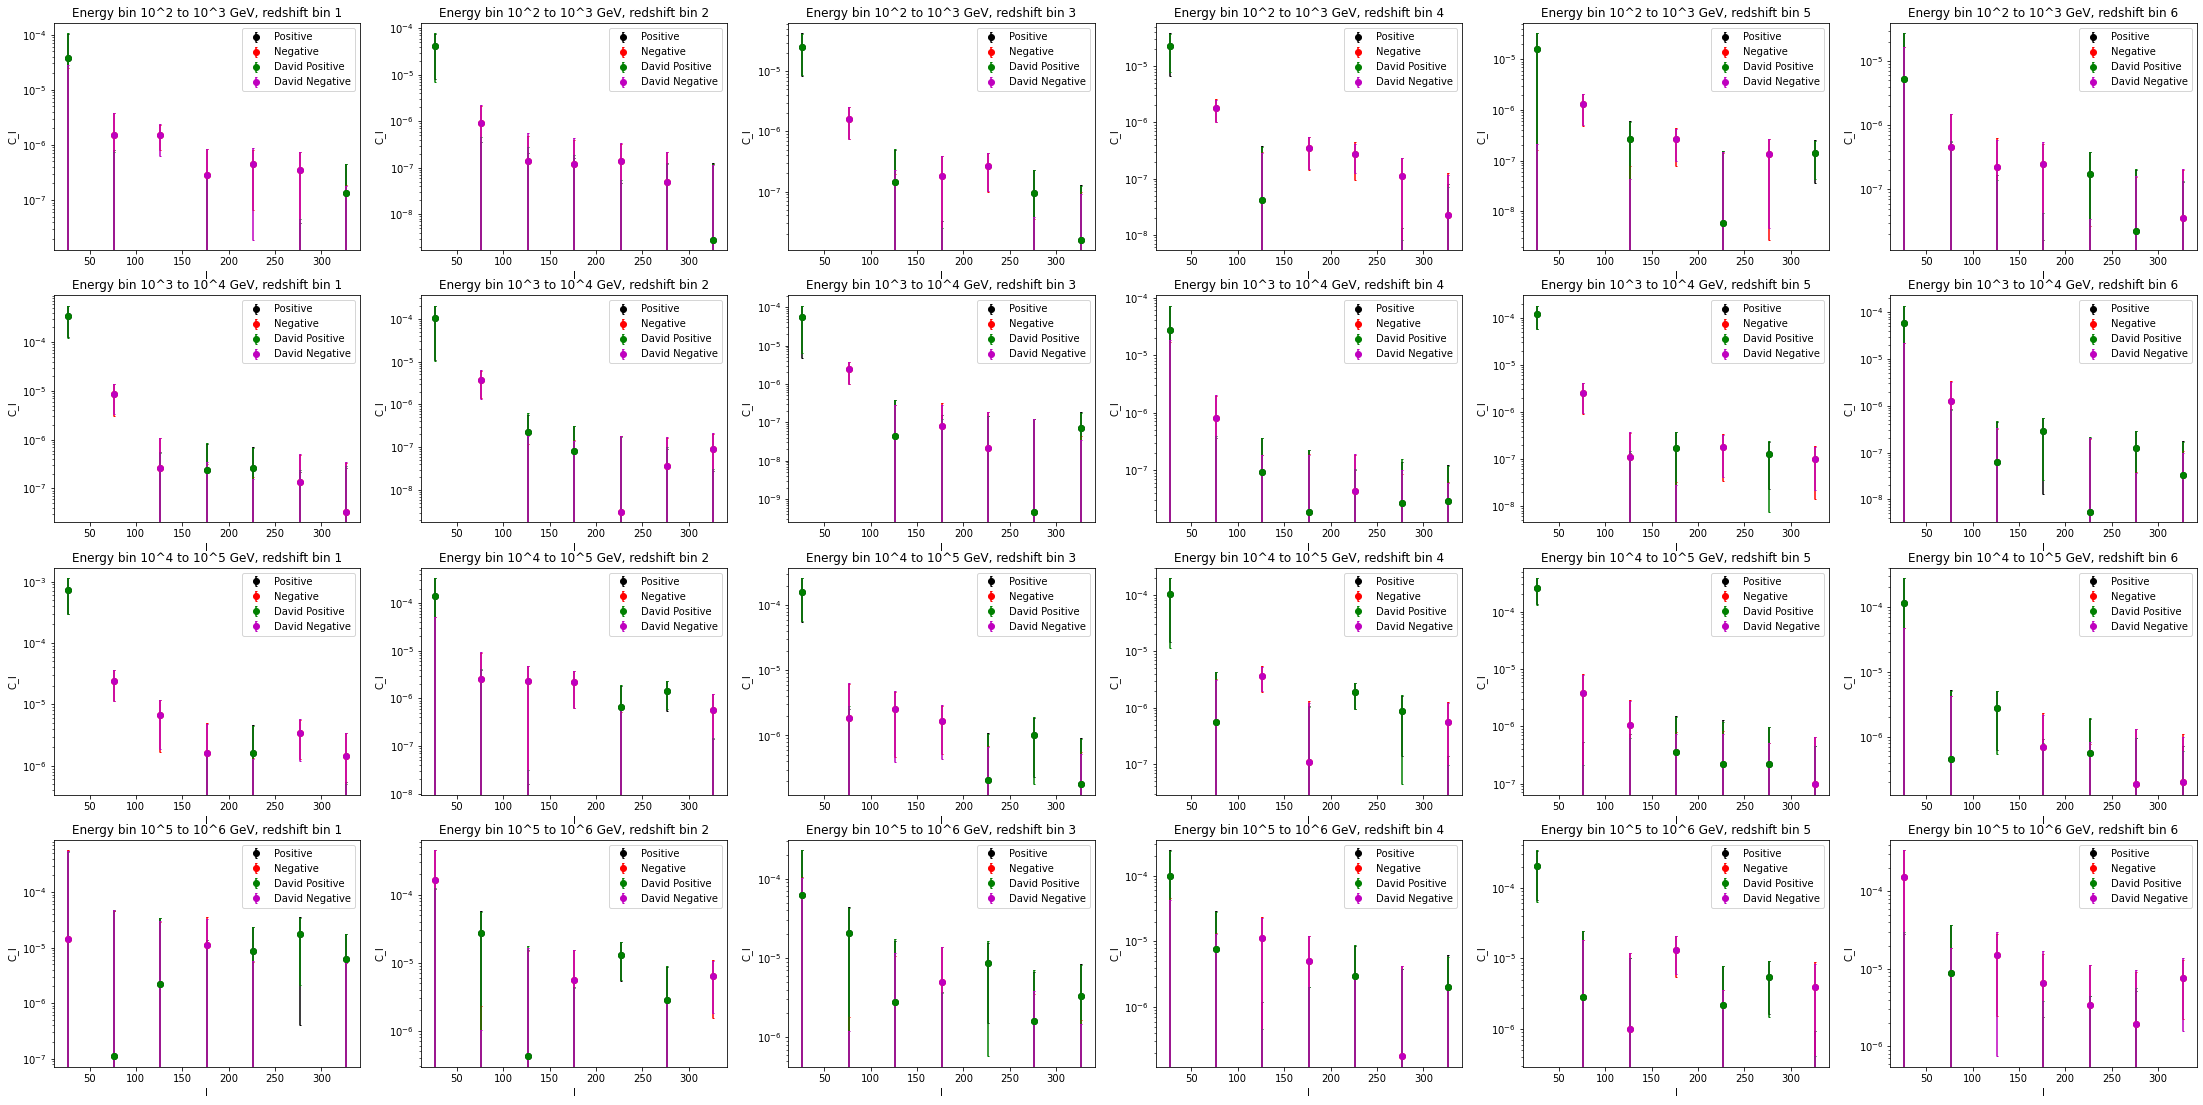

In [49]:
#saves cross correlation power spectra with errors in easy-to-read format

if CrossSpectraPDF == True and UseAeffWeights == True:

    #creates grid of subfigures
    fig, axs = plt.subplots(len(MapArray), len(GalMaps), figsize = (6.4*len(GalMaps), 4.8*len(MapArray)))

    #plots charts
    for i in range(len(MapArray)):
        for j in range(len(GalMaps)):
            axs[i,j].errorbar(l_avg, CrossNmt_cl[i][j], yerr = CrossJKNmt_cl_err[i][j], capsize = 1, 
                              fmt = 'o', label = 'Positive', c = 'k')
            axs[i,j].errorbar(l_avg, -CrossNmt_cl[i][j], yerr = CrossJKNmt_cl_err[i][j], capsize = 1, 
                              fmt = 'o', label = 'Negative', c = 'r')
            if ICDataset == 10:
                axs[i,j].errorbar(l_avg, cls_all[i, j, :], yerr = cl_errors[i, j, :], capsize = 1, 
                                  fmt = 'o', label = 'David Positive', c = 'g')
                axs[i,j].errorbar(l_avg, -cls_all[i, j, :], yerr = cl_errors[i, j, :], capsize = 1, 
                                  fmt = 'o', label = 'David Negative', c = 'm')
            #formatting
            axs[i,j].set_yscale('log')
            axs[i,j].set_title(f'Energy bin 10^{ICEMapBands[i][0]} to 10^{ICEMapBands[i][1]} GeV, ' + 
                           f'redshift bin {j+1}')
            axs[i,j].set_xlabel('l')
            axs[i,j].set_ylabel('C_l')
            axs[i,j].legend()

    #saves combined figure as pdf
    plt.savefig(f'CrossPowerSpectra{ICDataset}.pdf')
        

In [50]:
#finds null hypothesis from jackknife errors for each energy/redshift bin combination

CrossJKNullHyp = []

for i in range(len(GalMaps)): #each redshift bin
    
    CrossJKNullHyp.append(0)
    
    for j in range(len(MapArray)): #each energy bin
        
        CrossJKNullHyp[i] += np.sum(np.array(CrossNmt_cl[j][i][lminind])**2/(2*(CrossJKNmt_cl_err[j][i][lminind])**2))

    print(f'Null hypothesis for redshift bin {i+1}: {CrossJKNullHyp[i]}')

Null hypothesis for redshift bin 1: 10.782405911341977
Null hypothesis for redshift bin 2: 9.08520190057041
Null hypothesis for redshift bin 3: 9.854740703813334
Null hypothesis for redshift bin 4: 12.199801164605105
Null hypothesis for redshift bin 5: 11.451084465379992
Null hypothesis for redshift bin 6: 5.391586303316183


### Theoretical Errors

In [51]:
#creates workspace
cw = nmt.NmtCovarianceWorkspace()
cw.compute_coupling_coefficients(CrossMapArrayField[0], CrossGalMapsField[0], 
                                 CrossMapArrayField[0], CrossGalMapsField[0])

In [52]:
#calculates cls for use in calculating theoretical covariance

ICAna_cl = []
GalAna_cl = []
CrossAna_cl = []

#calculates fsky
AnaF_sky = 1 - (np.sum(CrossMask)/NPIX)

for i in range(len(MapArray)):
    ICAna_cl.append(hp.anafast(MapArray[i], MapArray[i])/AnaF_sky) #IceCube auto
    CrossAna_cl.append([])
    for j in range(len(GalMaps)):
        CrossAna_cl[i].append(hp.anafast(MapArray[i], GalMaps[j])/AnaF_sky) #cross
    
for i in range(len(GalMaps)):
    GalAna_cl.append(hp.anafast(GalMaps[i], GalMaps[i])/AnaF_sky) #galaxy auto

In [53]:
#calculates theoretical covariance
TheoryCovar = []
TheoryErrs = []
for i in range(len(MapArray)):
    TheoryCovar.append([])
    TheoryErrs.append([])
    for j in range(len(GalMaps)):
        TheoryCovar[i].append(nmt.gaussian_covariance(cw, 0, 0, 0, 0, 
                                              [ICAna_cl[i]], [CrossAna_cl[i][j]], 
                                              [CrossAna_cl[i][j]], [GalAna_cl[j]], Crossw))
        #calculates theoretical errors
        TheoryErrs[i].append(np.sqrt(np.diag(TheoryCovar[i][j])))

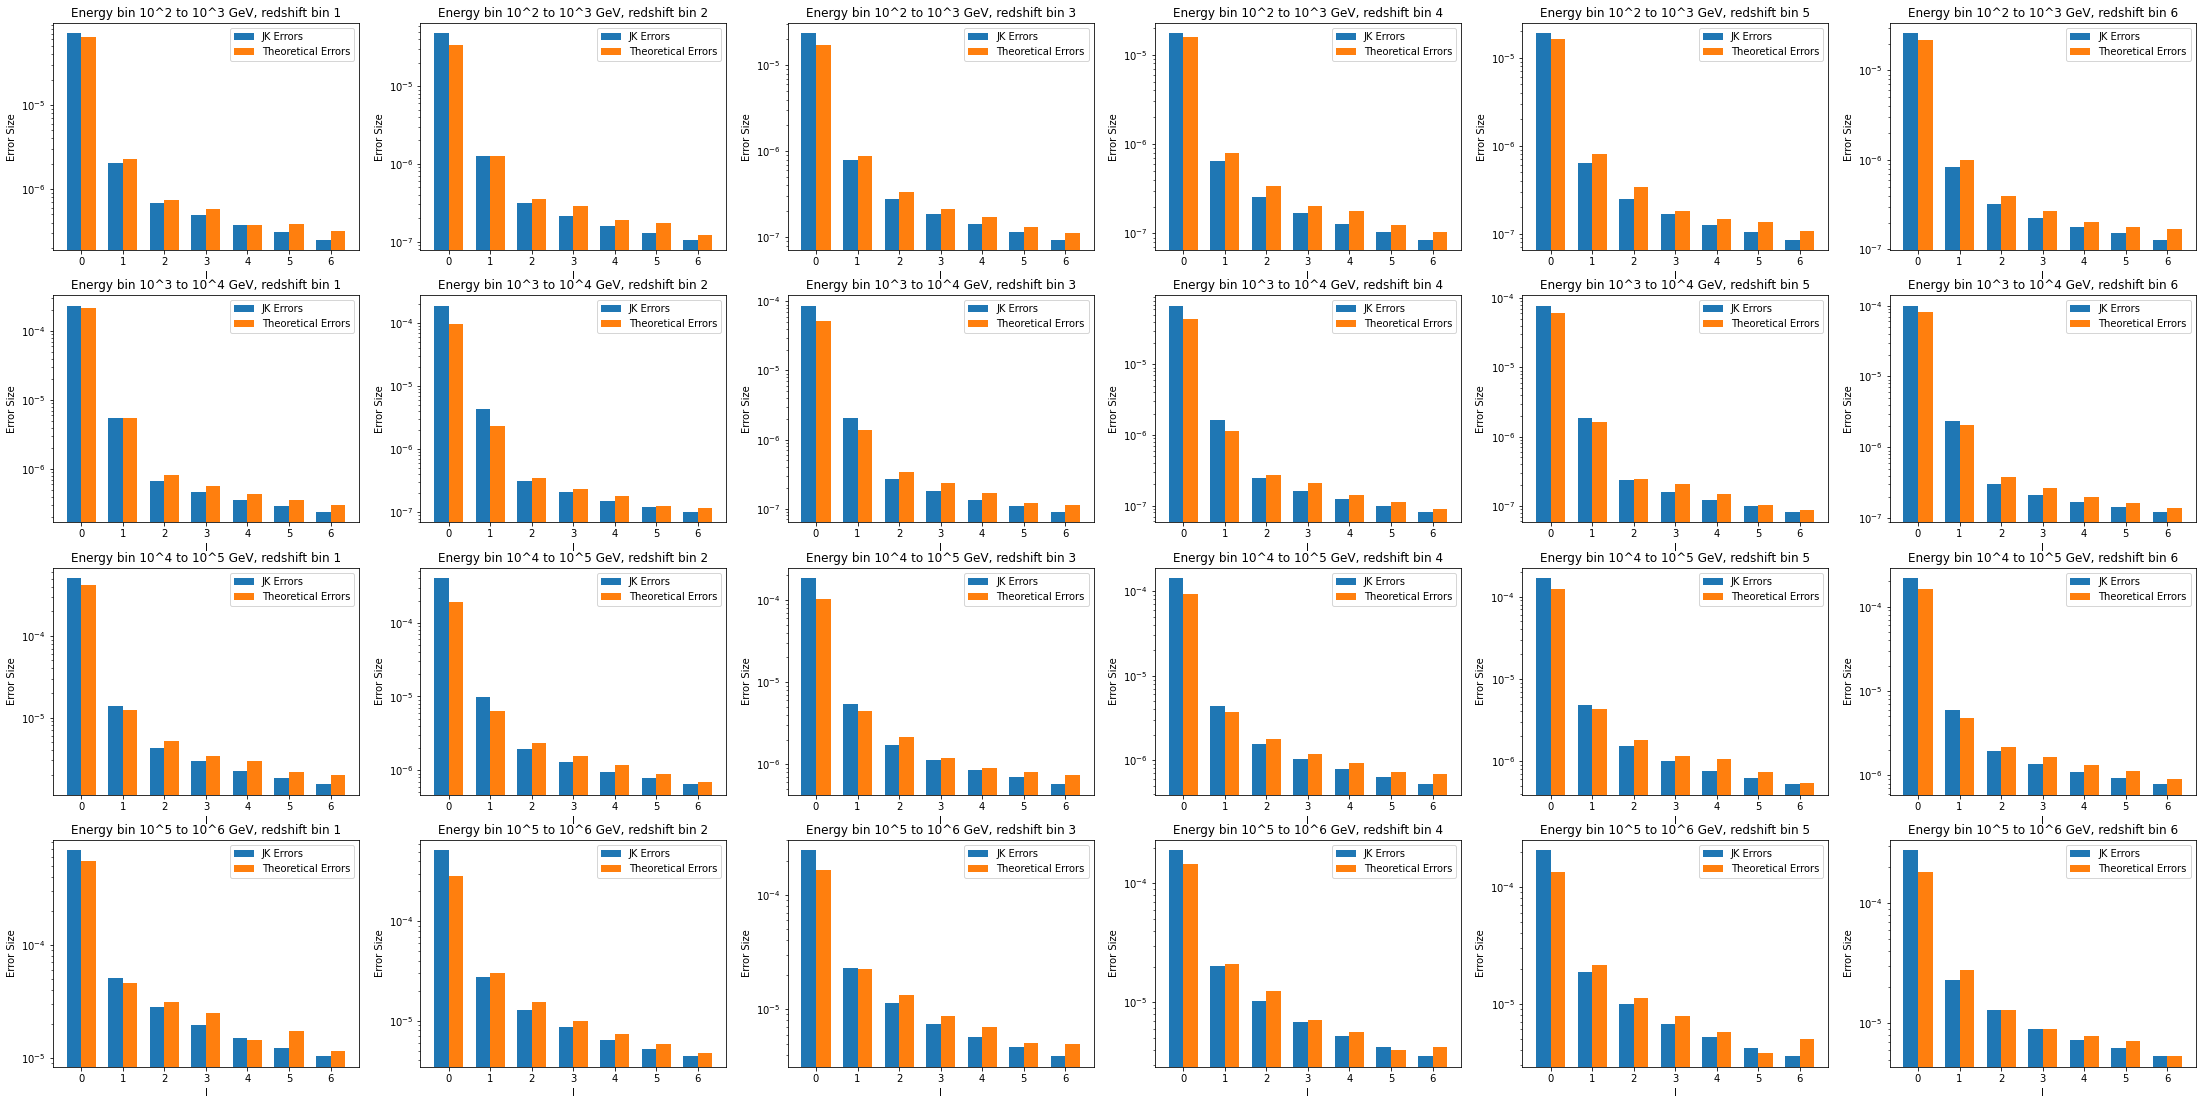

In [54]:
#compares jackknife and theoretical error size

#creates grid of subfigures
fig, axs = plt.subplots(len(MapArray), len(GalMaps), figsize = (6.4*len(GalMaps), 4.8*len(MapArray)))

#width and spacing of bars
x = np.arange(len(TheoryErrs[0][0]))
width = 0.35

#plots bar charts
for i in range(len(MapArray)):
    for j in range(len(GalMaps)):
        axs[i,j].bar(x - width/2, TheoryErrs[i][j], width, label = 'JK Errors')
        axs[i,j].bar(x + width/2, CrossJKNmt_cl_err[i][j], width, label = 'Theoretical Errors')
        #formatting
        axs[i,j].set_yscale('log')
        axs[i,j].set_title(f'Energy bin 10^{ICEMapBands[i][0]} to 10^{ICEMapBands[i][1]} GeV, ' + 
                           f'redshift bin {j+1}')
        axs[i,j].set_xlabel('l')
        axs[i,j].set_ylabel('Error Size')
        axs[i,j].legend()

#saves combined figure as pdf
plt.savefig(f'JKTheoreticalErrs{ICDataset}.pdf')